# Deep learning models for age prediction on EEG data

This notebook uses deep learning methods to predict the age of infants using EEG data. The EEG data is preprocessed as shown in the notebook 'Deep learning EEG_dataset preprocessing raw'. 

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_RAW_DATA, PATH_DATA_PROCESSED_DL, PATH_MODELS

## Load preprocessed data

The data can be found in 'PATH_DATA_PROCESSED_DL'. This is a single folder with all the data and metadata. The EEG data is in the .zarr files and the metadata is in .csv files. The .zarr files are divided in chunks of 1-second epochs from the same subject and the metadata contains the information like the subject's identification code and age. 

Ideally, all the data (epochs + age as label) is loaded in memory and models are trained on this data. The data must be split in train/validation/test and subjects shouldn't be in more than one of these splits. However, the data set is too large to fit in memory.

Therefore, a generator is used that loads the data on the fly from the files, tackling the issue of limited memory. Additionally, because epochs often contain a lot of noise, multiple random epochs of the same subjects at the same age (e.g. 40) can be averaged to create a new epoch. 

In [2]:
# Load all the metadata

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_DL)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_DL, file_name))[0] for file_name in fnmatch.filter(file_names, "*.zarr")]

# Step 3: Load all the metadata
frames = []

for idx, feature_file in enumerate(files):
    df_metadata = pd.read_csv(feature_file.replace("processed_raw_", "processed_metadata_") + ".csv")
    frames.append(df_metadata)

df_metadata = pd.concat(frames) 

# Step 4: Add missing age information based on the age group the subject is in
df_metadata['age_months'].fillna(df_metadata['age_group'], inplace=True)
df_metadata['age_days'].fillna(df_metadata['age_group']*30, inplace=True)
df_metadata['age_years'].fillna(df_metadata['age_group']/12, inplace=True)

# Step 5: List all the unique subject IDs
subject_ids = list(set(df_metadata["code"].tolist()))

In [3]:
from sklearn.model_selection import train_test_split

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

In [4]:
df_metadata

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,23,/Volumes/Seagate Expansion Drive/ePodium/Data/...,023_35_mc_mmn36,35,1052.0,35.066667,2.922222
0,337,/Volumes/Seagate Expansion Drive/ePodium/Data/...,337_23_jc_mmn_36_wk,23,692.0,23.066667,1.922222
0,456,/Volumes/Seagate Expansion Drive/ePodium/Data/...,456_23_md_mmn36_wk,23,691.0,23.033333,1.919444
0,328,/Volumes/Seagate Expansion Drive/ePodium/Data/...,328_23_jc_mmn36_wk,23,699.0,23.300000,1.941667
0,314,/Volumes/Seagate Expansion Drive/ePodium/Data/...,314_29_mmn_36_wk,29,877.0,29.233333,2.436111
...,...,...,...,...,...,...,...
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_29_jc_mmn25_wk,29,858.0,28.600000,2.383333
0,9,/Volumes/Seagate Expansion Drive/ePodium/Data/...,009_23_jc_mmn58,23,692.0,23.066667,1.922222
0,751,/Volumes/Seagate Expansion Drive/ePodium/Data/...,751-452-29m-jr-mmn36,29,869.0,28.966667,2.413889
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_17_jc_mmn25_wk,17,512.0,17.066667,1.422222


In [5]:
from dataset_generator import DataGenerator

In [6]:
train_generator = DataGenerator(list_IDs = IDs_train,
                                BASE_PATH = PATH_DATA_PROCESSED_DL,
                                metadata = df_metadata,
                                n_average = 30,
                                batch_size = 10,
                                iter_per_epoch = 30,
                                n_timepoints = 501, 
                                n_channels=30, 
                                shuffle=True)

train_generator_noise = DataGenerator(list_IDs = IDs_train,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator = DataGenerator(list_IDs = IDs_val,
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

test_generator = DataGenerator(list_IDs = IDs_test,
                               BASE_PATH = PATH_DATA_PROCESSED_DL,
                               metadata = df_metadata,
                               n_average = 30,
                               batch_size = 10,
                               iter_per_epoch = 100,
                               n_timepoints = 501,
                               n_channels=30,
                               shuffle=True)

# Testing with best model from initial experiments (InceptionTime)

In [10]:
n_timesteps = 501
n_features = 30
n_outputs = 1

input_shape = (n_timesteps, n_features)

In [11]:
# Helper functions

def evaluate_model(model):
    """ Evaluates the model """
    model.evaluate(train_generator)
    model.evaluate(val_generator)
    model.evaluate(test_generator) 
    
def print_few_predictions(model):
    """ Prints a few predictions, as a sanity check """
    x_test, y_test = test_generator.__getitem__(0)

    print(model.predict(x_test))
    print(y_test)
    
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
output_filename = 'Inception_regressor_05'
# 'Inception_regressor_01' (n_average = 40, gaussian_noise = 0.01, MAE)
# 'Inception_regressor_02' (n_average = 1, gaussian_noise = 0.01, MAE)
# 'Inception_regressor_03' (n_average = 40, gaussian_noise = 0.01, MSE)
# 'Inception_regressor_04' (n_average = 1, gaussian_noise = 0.01, MSE)
# 'Inception_regressor_05' (n_average = 100, gaussian_noise = 0.01, MAE)

output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.0001, verbose=1)

In [14]:
import tensorflow as tf
import numpy as np
import time

from utils import save_logs
from utils import calculate_metrics
from utils import save_test_duration


class Regressor_Inception:

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=41, nb_epochs=1500):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'inception_model_init.hdf5')

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = tf.keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = tf.keras.layers.Concatenate(axis=2)(conv_list)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        x = tf.keras.layers.Add()([shortcut_y, out_tensor])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = tf.keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=50)(x)
        flat_layer = tf.keras.layers.Flatten()(pooling_layer)
        dense_layer = tf.keras.layers.Dense(128)(flat_layer)
        output_layer = tf.keras.layers.Dense(1)(dense_layer)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
#         model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                      metrics=[tf.keras.metrics.RootMeanSquaredError(),
                               tf.keras.metrics.MeanAbsoluteError()])

        return model

    def fit(self, x, validation_data, plot_test_acc=False):
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        hist = self.model.fit(x=x, validation_data=validation_data,
                              batch_size=mini_batch_size, epochs=self.nb_epochs,
                              verbose=self.verbose, callbacks=self.callbacks)

        self.model.save(self.output_directory + 'inception_last_model.hdf5')

        return hist

    def predict(self, x_test, y_true, x_train, y_train, y_test, return_df_metrics=True):
        start_time = time.time()
        model_path = self.output_directory + 'inception_best_model.hdf5'
        model = tf.keras.models.load_model(model_path)
        y_pred = model.predict(x_test, batch_size=self.batch_size)
        if return_df_metrics:
            y_pred = np.argmax(y_pred, axis=1)
            df_metrics = calculate_metrics(y_true, y_pred, 0.0)
            return df_metrics
        else:
            test_duration = time.time() - start_time
            save_test_duration(self.output_directory + 'test_duration.csv', test_duration)
            return y_pred

In [15]:
model = Regressor_Inception(PATH_MODELS, input_shape, 1, verbose=True).model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 501, 30)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 501, 32)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 501, 30)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 501, 32)      40960       conv1d[0][0]                     
______________________________________________________________________________________________

In [96]:
%%time

epochs = 1500

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
143/143 [==============================] - 249s 2s/step - loss: 14.8795 - root_mean_squared_error: 21.7512 - mean_absolute_error: 14.8795 - val_loss: 14.4589 - val_root_mean_squared_error: 18.1789 - val_mean_absolute_error: 14.4589

Epoch 00001: val_loss improved from inf to 14.45891, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 2/1500
143/143 [==============================] - 238s 2s/step - loss: 8.9878 - root_mean_squared_error: 11.2585 - mean_absolute_error: 8.9878 - val_loss: 8.4816 - val_root_mean_squared_error: 10.7197 - val_mean_absolute_error: 8.4816

Epoch 00002: val_loss improved from 14.45891 to 8.48164, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 3/1500
143/143 [==============================] - 241s 2s/step - loss: 7.9297 - root_mean_squared_error: 9.8073 - mean_absolute_error: 7.9297 - val_loss: 8.62


Epoch 00024: val_loss did not improve from 5.82968
Epoch 25/1500
143/143 [==============================] - 249s 2s/step - loss: 5.9342 - root_mean_squared_error: 7.4770 - mean_absolute_error: 5.9342 - val_loss: 5.8190 - val_root_mean_squared_error: 7.3576 - val_mean_absolute_error: 5.8190

Epoch 00025: val_loss improved from 5.82968 to 5.81904, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Inception_regressor_05.hdf5
Epoch 26/1500
143/143 [==============================] - 244s 2s/step - loss: 5.8491 - root_mean_squared_error: 7.5007 - mean_absolute_error: 5.8491 - val_loss: 6.2931 - val_root_mean_squared_error: 7.9237 - val_mean_absolute_error: 6.2931

Epoch 00026: val_loss did not improve from 5.81904
Epoch 27/1500
143/143 [==============================] - 234s 2s/step - loss: 5.7424 - root_mean_squared_error: 7.2581 - mean_absolute_error: 5.7424 - val_loss: 5.7668 - val_root_mean_squared_error: 7.2636 - val_mean_absolute_error: 5.7668


143/143 [==============================] - 316s 2s/step - loss: 5.1042 - root_mean_squared_error: 6.6133 - mean_absolute_error: 5.1042 - val_loss: 5.6670 - val_root_mean_squared_error: 7.2707 - val_mean_absolute_error: 5.6670

Epoch 00078: val_loss did not improve from 5.23083
Epoch 79/1500
143/143 [==============================] - 321s 2s/step - loss: 4.9956 - root_mean_squared_error: 6.3485 - mean_absolute_error: 4.9956 - val_loss: 5.4951 - val_root_mean_squared_error: 7.2871 - val_mean_absolute_error: 5.4951

Epoch 00079: val_loss did not improve from 5.23083
Epoch 80/1500
143/143 [==============================] - 324s 2s/step - loss: 5.1040 - root_mean_squared_error: 6.4311 - mean_absolute_error: 5.1040 - val_loss: 5.6553 - val_root_mean_squared_error: 7.0254 - val_mean_absolute_error: 5.6553

Epoch 00080: val_loss did not improve from 5.23083
Epoch 81/1500
143/143 [==============================] - 324s 2s/step - loss: 4.8514 - root_mean_squared_error: 6.2461 - mean_absolute_err

143/143 [==============================] - 303s 2s/step - loss: 4.9634 - root_mean_squared_error: 6.4851 - mean_absolute_error: 4.9634 - val_loss: 6.0805 - val_root_mean_squared_error: 7.7360 - val_mean_absolute_error: 6.0805

Epoch 00106: val_loss did not improve from 5.23083
Epoch 107/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9089 - root_mean_squared_error: 6.3690 - mean_absolute_error: 4.9089 - val_loss: 5.7419 - val_root_mean_squared_error: 7.3350 - val_mean_absolute_error: 5.7419

Epoch 00107: val_loss did not improve from 5.23083
Epoch 108/1500
143/143 [==============================] - 324s 2s/step - loss: 4.6513 - root_mean_squared_error: 5.9217 - mean_absolute_error: 4.6513 - val_loss: 6.1858 - val_root_mean_squared_error: 7.8471 - val_mean_absolute_error: 6.1858

Epoch 00108: val_loss did not improve from 5.23083
Epoch 109/1500
143/143 [==============================] - 321s 2s/step - loss: 5.0534 - root_mean_squared_error: 6.3555 - mean_absolute_


Epoch 00133: val_loss did not improve from 5.20694
Epoch 134/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9270 - root_mean_squared_error: 6.2901 - mean_absolute_error: 4.9270 - val_loss: 5.5962 - val_root_mean_squared_error: 7.2905 - val_mean_absolute_error: 5.5962

Epoch 00134: val_loss did not improve from 5.20694
Epoch 135/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8693 - root_mean_squared_error: 6.1092 - mean_absolute_error: 4.8693 - val_loss: 5.6170 - val_root_mean_squared_error: 7.3019 - val_mean_absolute_error: 5.6170

Epoch 00135: val_loss did not improve from 5.20694
Epoch 136/1500
143/143 [==============================] - 323s 2s/step - loss: 4.7565 - root_mean_squared_error: 6.1799 - mean_absolute_error: 4.7565 - val_loss: 5.7584 - val_root_mean_squared_error: 7.4199 - val_mean_absolute_error: 5.7584

Epoch 00136: val_loss did not improve from 5.20694
Epoch 137/1500
143/143 [==============================] - 323s 2s/ste

143/143 [==============================] - 323s 2s/step - loss: 4.6652 - root_mean_squared_error: 6.0196 - mean_absolute_error: 4.6652 - val_loss: 6.1782 - val_root_mean_squared_error: 7.6756 - val_mean_absolute_error: 6.1782

Epoch 00189: val_loss did not improve from 5.04051
Epoch 190/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8163 - root_mean_squared_error: 6.2274 - mean_absolute_error: 4.8163 - val_loss: 5.3501 - val_root_mean_squared_error: 6.8194 - val_mean_absolute_error: 5.3501

Epoch 00190: val_loss did not improve from 5.04051
Epoch 191/1500
143/143 [==============================] - 323s 2s/step - loss: 4.8694 - root_mean_squared_error: 6.2544 - mean_absolute_error: 4.8694 - val_loss: 5.5560 - val_root_mean_squared_error: 7.1667 - val_mean_absolute_error: 5.5560

Epoch 00191: val_loss did not improve from 5.04051
Epoch 192/1500
143/143 [==============================] - 324s 2s/step - loss: 4.8435 - root_mean_squared_error: 6.1235 - mean_absolute_


Epoch 00216: val_loss did not improve from 4.69455
Epoch 217/1500
143/143 [==============================] - 293s 2s/step - loss: 4.8800 - root_mean_squared_error: 6.2364 - mean_absolute_error: 4.8800 - val_loss: 5.8352 - val_root_mean_squared_error: 7.3876 - val_mean_absolute_error: 5.8352

Epoch 00217: val_loss did not improve from 4.69455
Epoch 218/1500
143/143 [==============================] - 284s 2s/step - loss: 4.6264 - root_mean_squared_error: 5.8839 - mean_absolute_error: 4.6264 - val_loss: 5.5292 - val_root_mean_squared_error: 7.0442 - val_mean_absolute_error: 5.5292

Epoch 00218: val_loss did not improve from 4.69455
Epoch 219/1500
143/143 [==============================] - 311s 2s/step - loss: 5.0450 - root_mean_squared_error: 6.4782 - mean_absolute_error: 5.0450 - val_loss: 5.7673 - val_root_mean_squared_error: 7.2827 - val_mean_absolute_error: 5.7673

Epoch 00219: val_loss did not improve from 4.69455
Epoch 220/1500
143/143 [==============================] - 276s 2s/ste


Epoch 00244: val_loss did not improve from 4.69455
Epoch 245/1500
143/143 [==============================] - 1083s 8s/step - loss: 4.8373 - root_mean_squared_error: 6.3008 - mean_absolute_error: 4.8373 - val_loss: 5.7162 - val_root_mean_squared_error: 7.2399 - val_mean_absolute_error: 5.7162

Epoch 00245: val_loss did not improve from 4.69455
Epoch 246/1500
143/143 [==============================] - 854s 6s/step - loss: 4.7068 - root_mean_squared_error: 6.0775 - mean_absolute_error: 4.7068 - val_loss: 5.7267 - val_root_mean_squared_error: 7.3911 - val_mean_absolute_error: 5.7267

Epoch 00246: val_loss did not improve from 4.69455
Epoch 247/1500
143/143 [==============================] - 484s 3s/step - loss: 4.9483 - root_mean_squared_error: 6.2214 - mean_absolute_error: 4.9483 - val_loss: 5.1563 - val_root_mean_squared_error: 6.7706 - val_mean_absolute_error: 5.1563

Epoch 00247: val_loss did not improve from 4.69455
Epoch 248/1500
143/143 [==============================] - 319s 2s/st


Epoch 00272: val_loss did not improve from 4.69455
Epoch 273/1500
143/143 [==============================] - 289s 2s/step - loss: 4.9148 - root_mean_squared_error: 6.3654 - mean_absolute_error: 4.9148 - val_loss: 5.6706 - val_root_mean_squared_error: 7.2174 - val_mean_absolute_error: 5.6706

Epoch 00273: val_loss did not improve from 4.69455
Epoch 274/1500
143/143 [==============================] - 276s 2s/step - loss: 4.6158 - root_mean_squared_error: 6.1187 - mean_absolute_error: 4.6158 - val_loss: 5.6966 - val_root_mean_squared_error: 7.5244 - val_mean_absolute_error: 5.6966

Epoch 00274: val_loss did not improve from 4.69455
Epoch 275/1500
143/143 [==============================] - 298s 2s/step - loss: 5.0629 - root_mean_squared_error: 6.5235 - mean_absolute_error: 5.0629 - val_loss: 6.1959 - val_root_mean_squared_error: 7.6484 - val_mean_absolute_error: 6.1959

Epoch 00275: val_loss did not improve from 4.69455
Epoch 276/1500
143/143 [==============================] - 287s 2s/ste


Epoch 00300: val_loss did not improve from 4.69455
Epoch 301/1500
143/143 [==============================] - 321s 2s/step - loss: 4.8422 - root_mean_squared_error: 6.2162 - mean_absolute_error: 4.8422 - val_loss: 5.7874 - val_root_mean_squared_error: 7.3298 - val_mean_absolute_error: 5.7874

Epoch 00301: val_loss did not improve from 4.69455
Epoch 302/1500
143/143 [==============================] - 323s 2s/step - loss: 4.9055 - root_mean_squared_error: 6.4589 - mean_absolute_error: 4.9055 - val_loss: 5.7145 - val_root_mean_squared_error: 7.0399 - val_mean_absolute_error: 5.7145

Epoch 00302: val_loss did not improve from 4.69455
Epoch 303/1500
143/143 [==============================] - 322s 2s/step - loss: 4.8142 - root_mean_squared_error: 6.1713 - mean_absolute_error: 4.8142 - val_loss: 5.3505 - val_root_mean_squared_error: 6.8226 - val_mean_absolute_error: 5.3505

Epoch 00303: val_loss did not improve from 4.69455
Epoch 304/1500
143/143 [==============================] - 300s 2s/ste

In [82]:
evaluate_model(model)

35/35 [==============================] - 2s 62ms/step - loss: 70.8651 - root_mean_squared_error: 8.4181 - mean_absolute_error: 6.8559 0s - loss: 75.1631 - root_mean_squared_error: 8.6697 - m


In [83]:
print_few_predictions(model)

[[16.62974 ]
 [16.380692]
 [19.520061]
 [25.405197]
 [18.500408]
 [33.71194 ]
 [23.947464]
 [33.241116]
 [16.14786 ]
 [28.907635]]
[[17.06666667]
 [23.06666667]
 [11.16666667]
 [41.1       ]
 [17.        ]
 [40.96666667]
 [23.06666667]
 [34.93333333]
 [29.03333333]
 [23.03333333]]


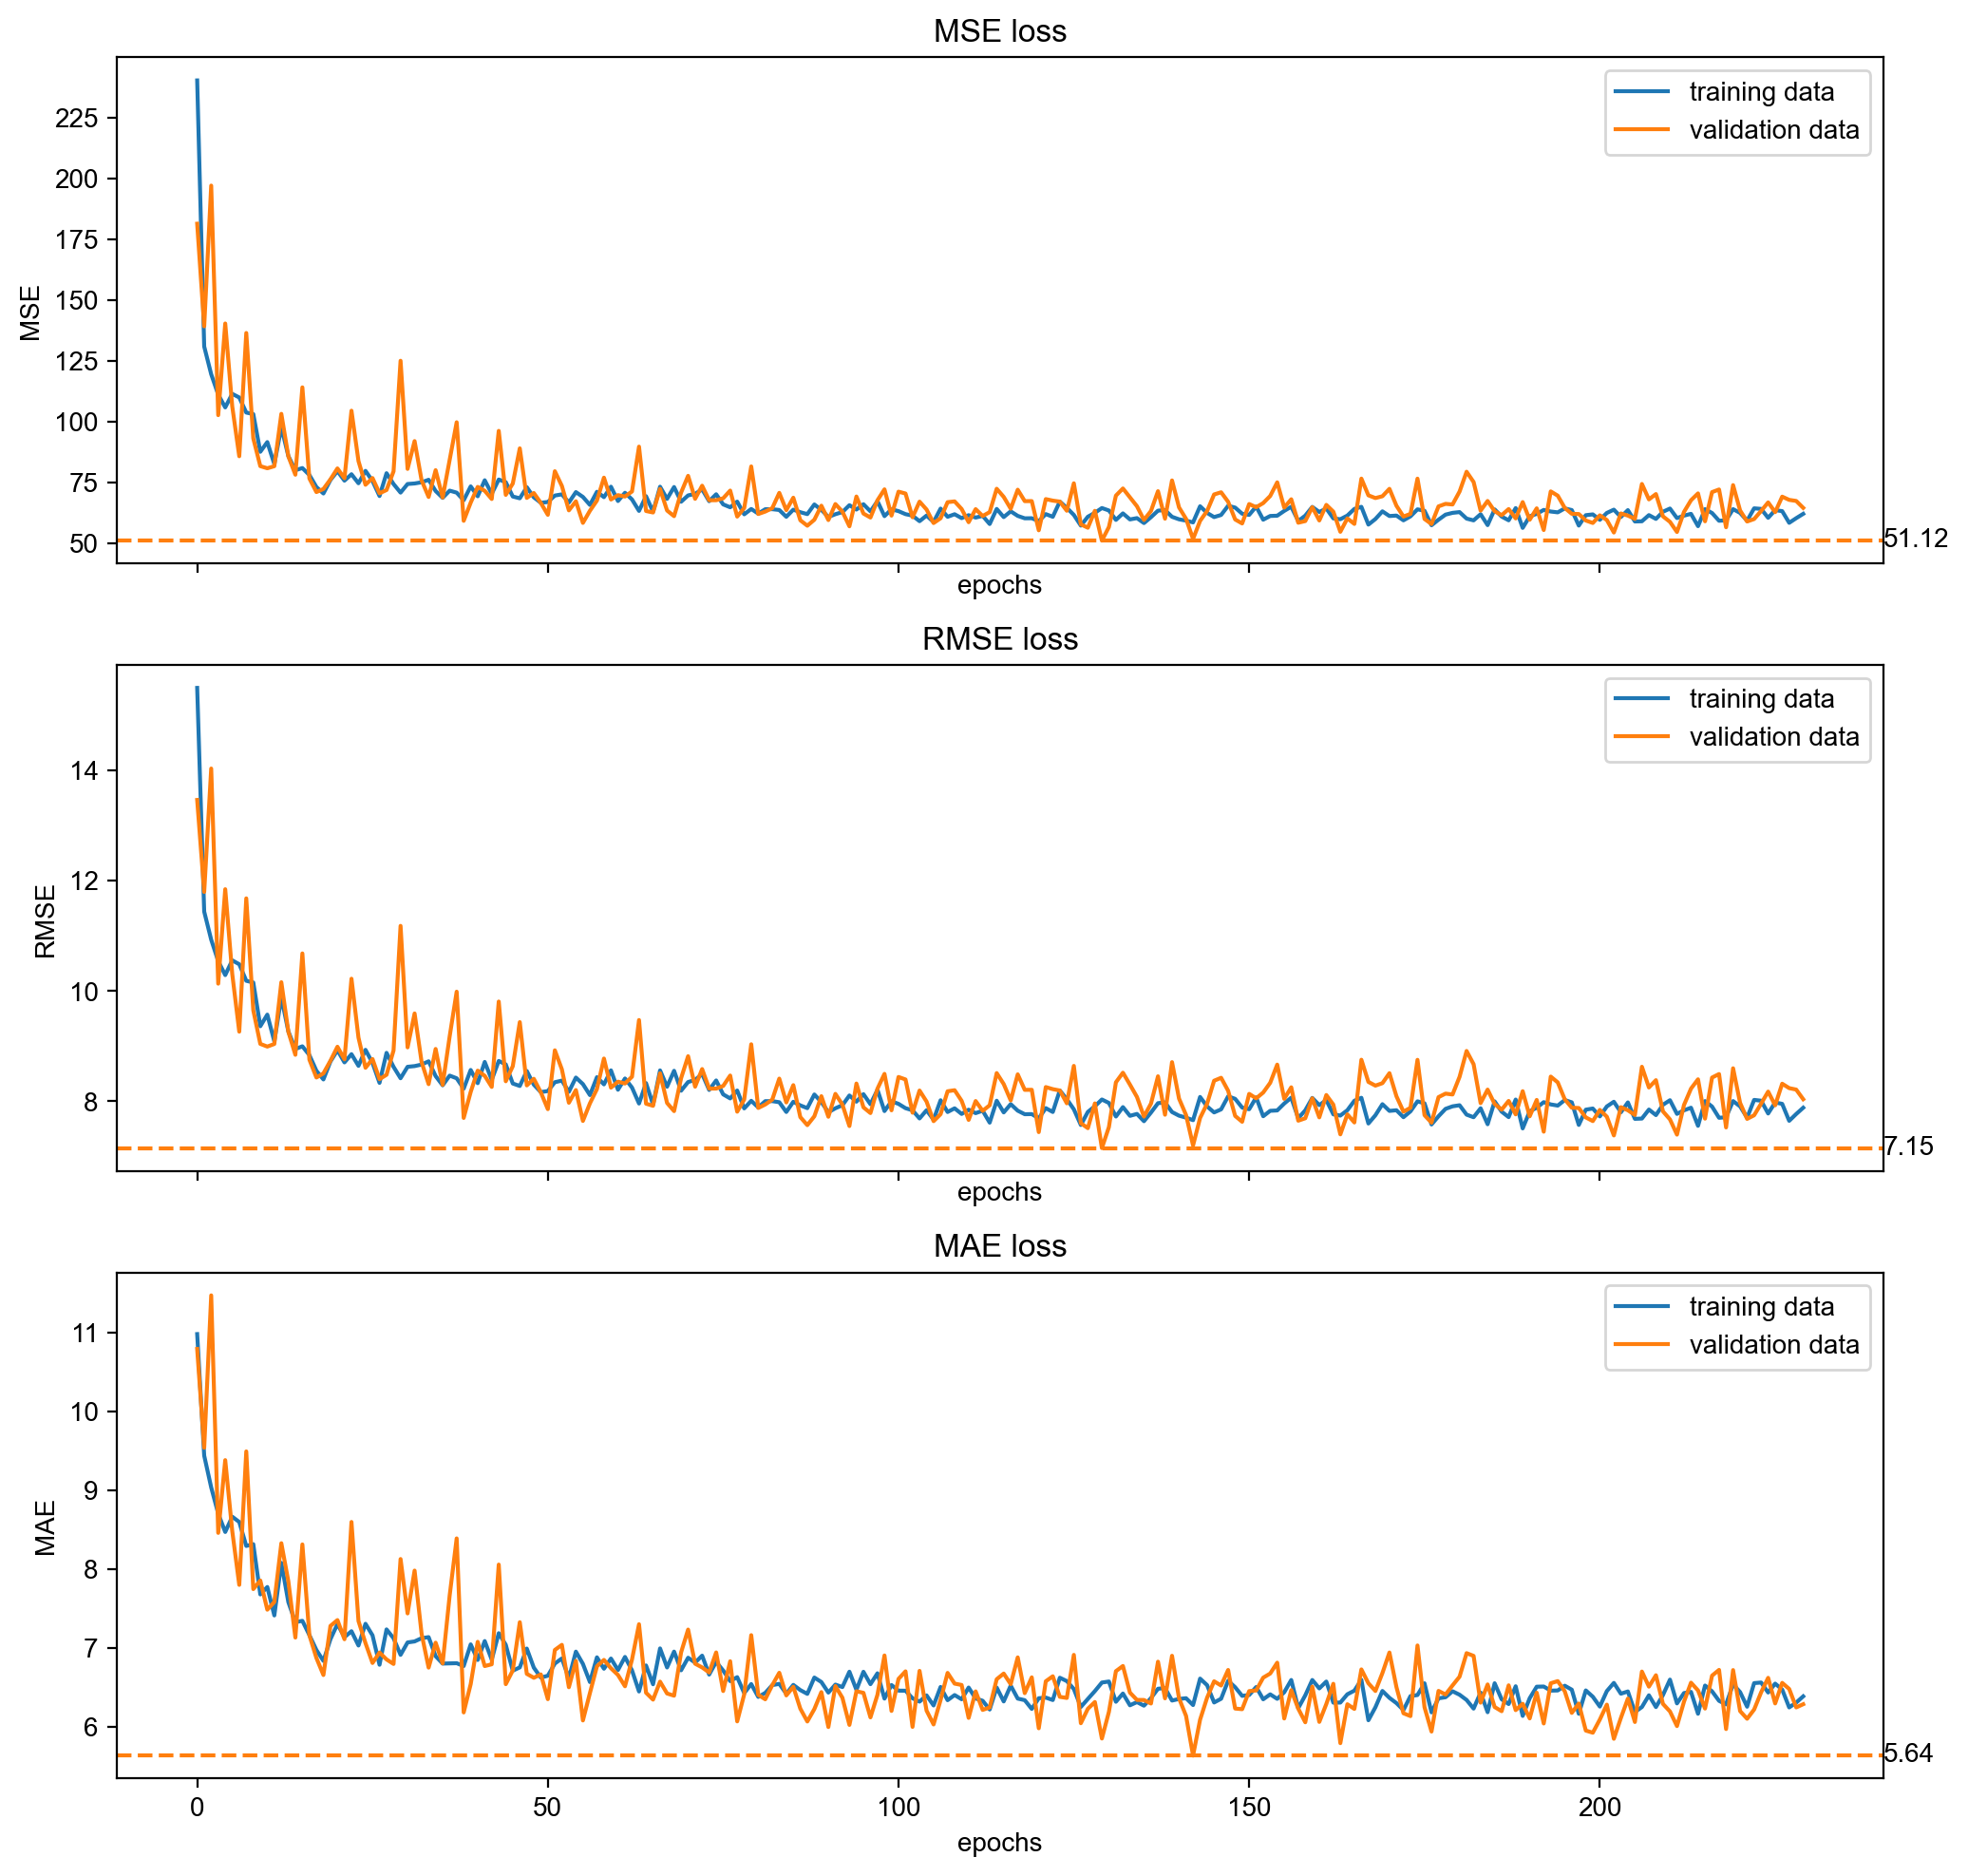

In [84]:
plot_loss(history)

# Testing of different architectures

Below we will test multiple different architectures, most of them as discussed in "Deep learning for time series classification: a review", by Ismail Fawaz et al (2019). Most of them are inspired again on other papers. Refer to the Ismail Fawaz paper for the original papers.

1. Fully-connected NN
2. CNN
3. ResNet
4. Encoder
5. Time-CNN
6. MCDCNN (Multi Channel Deep CNN)
7. MCNN (Multi-scale CNN)
8. t-LeNet

Other architectures to test:

- InceptionTime (Done above)
- BLSTM-LSTM 
- Echo State Network

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)

# 1. Fully connected NN

In [17]:
def fully_connected_model():
    """ Returns the fully connected model from Ismail Fawaz et al. (2019). """
        
    model = Sequential()    
    model.add(Input(shape=input_shape))
    
    model.add(Dropout(.1))
    model.add(Dense(500, activation='relu'))
    
    model.add(Dropout(.2))
    model.add(Dense(500, activation='relu'))
    
    model.add(Dropout(.2))
    model.add(Dense(500, activation='relu'))
    
    model.add(Dropout(.3))
    model.add(Dense(1))
    
    return model

In [18]:
model = fully_connected_model()

optimizer = Adadelta(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# Fully_connected_regressor_01: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
output_filename = 'Fully_connected_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0.0001, verbose=1)

In [ ]:
%%time

epochs = 5000 #1500 gedaan
# ReduceLROnPlateau reducing learning rate to 0.0012499999720603228

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/5000
143/143 [==============================] - 88s 612ms/step - loss: 820.0791 - root_mean_squared_error: 28.6212 - mean_absolute_error: 26.5912 - val_loss: 192.6338 - val_root_mean_squared_error: 13.8793 - val_mean_absolute_error: 11.3134

Epoch 00001: val_loss improved from inf to 192.63383, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_01.hdf5
Epoch 2/5000
143/143 [==============================] - 85s 595ms/step - loss: 164.1908 - root_mean_squared_error: 12.7977 - mean_absolute_error: 10.3831 - val_loss: 119.9867 - val_root_mean_squared_error: 10.9538 - val_mean_absolute_error: 9.0416

Epoch 00002: val_loss improved from 192.63383 to 119.98668, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_01.hdf5
Epoch 3/5000
143/143 [==============================] - 86s 599ms/step - loss: 125.9578 - root_mean_squared_error: 11.2221 - mean_absolut


Epoch 00025: val_loss did not improve from 99.83682
Epoch 26/5000
143/143 [==============================] - 94s 658ms/step - loss: 106.7969 - root_mean_squared_error: 10.3317 - mean_absolute_error: 8.4976 - val_loss: 123.0908 - val_root_mean_squared_error: 11.0946 - val_mean_absolute_error: 9.5016

Epoch 00026: val_loss did not improve from 99.83682
Epoch 27/5000
143/143 [==============================] - 92s 645ms/step - loss: 116.9741 - root_mean_squared_error: 10.8122 - mean_absolute_error: 9.1185 - val_loss: 108.4594 - val_root_mean_squared_error: 10.4144 - val_mean_absolute_error: 8.6970

Epoch 00027: val_loss did not improve from 99.83682
Epoch 28/5000
143/143 [==============================] - 97s 675ms/step - loss: 111.3828 - root_mean_squared_error: 10.5528 - mean_absolute_error: 8.8271 - val_loss: 116.1830 - val_root_mean_squared_error: 10.7788 - val_mean_absolute_error: 9.1698

Epoch 00028: val_loss did not improve from 99.83682
Epoch 29/5000
143/143 [=====================

143/143 [==============================] - 97s 677ms/step - loss: 115.0858 - root_mean_squared_error: 10.7258 - mean_absolute_error: 8.9718 - val_loss: 118.5684 - val_root_mean_squared_error: 10.8889 - val_mean_absolute_error: 9.2627

Epoch 00053: val_loss did not improve from 99.83682
Epoch 54/5000
143/143 [==============================] - 93s 653ms/step - loss: 110.8824 - root_mean_squared_error: 10.5263 - mean_absolute_error: 8.7898 - val_loss: 115.9137 - val_root_mean_squared_error: 10.7663 - val_mean_absolute_error: 9.0913

Epoch 00054: val_loss did not improve from 99.83682
Epoch 55/5000
143/143 [==============================] - 97s 680ms/step - loss: 108.8997 - root_mean_squared_error: 10.4328 - mean_absolute_error: 8.7031 - val_loss: 113.3504 - val_root_mean_squared_error: 10.6466 - val_mean_absolute_error: 8.9574

Epoch 00055: val_loss did not improve from 99.83682
Epoch 56/5000
143/143 [==============================] - 96s 672ms/step - loss: 115.1519 - root_mean_squared_er

143/143 [==============================] - 94s 658ms/step - loss: 116.9295 - root_mean_squared_error: 10.8114 - mean_absolute_error: 9.1437 - val_loss: 110.5401 - val_root_mean_squared_error: 10.5138 - val_mean_absolute_error: 9.0050

Epoch 00107: val_loss did not improve from 99.83682
Epoch 108/5000
143/143 [==============================] - 92s 646ms/step - loss: 114.8872 - root_mean_squared_error: 10.7167 - mean_absolute_error: 8.9777 - val_loss: 103.5211 - val_root_mean_squared_error: 10.1745 - val_mean_absolute_error: 8.5256

Epoch 00108: val_loss did not improve from 99.83682
Epoch 109/5000
143/143 [==============================] - 91s 640ms/step - loss: 107.7014 - root_mean_squared_error: 10.3768 - mean_absolute_error: 8.5857 - val_loss: 102.4009 - val_root_mean_squared_error: 10.1193 - val_mean_absolute_error: 8.4703

Epoch 00109: val_loss did not improve from 99.83682
Epoch 110/5000
143/143 [==============================] - 93s 654ms/step - loss: 111.1384 - root_mean_squared

143/143 [==============================] - 95s 661ms/step - loss: 103.7715 - root_mean_squared_error: 10.1810 - mean_absolute_error: 8.5289 - val_loss: 103.6620 - val_root_mean_squared_error: 10.1815 - val_mean_absolute_error: 8.5869

Epoch 00160: val_loss did not improve from 97.44319
Epoch 161/5000
143/143 [==============================] - 96s 670ms/step - loss: 110.6845 - root_mean_squared_error: 10.5183 - mean_absolute_error: 8.7367 - val_loss: 111.8944 - val_root_mean_squared_error: 10.5780 - val_mean_absolute_error: 8.8732

Epoch 00161: val_loss did not improve from 97.44319
Epoch 162/5000
143/143 [==============================] - 94s 657ms/step - loss: 111.4277 - root_mean_squared_error: 10.5524 - mean_absolute_error: 8.8477 - val_loss: 106.1589 - val_root_mean_squared_error: 10.3033 - val_mean_absolute_error: 8.7506

Epoch 00162: val_loss did not improve from 97.44319
Epoch 163/5000
143/143 [==============================] - 94s 660ms/step - loss: 111.7314 - root_mean_squared

143/143 [==============================] - 96s 671ms/step - loss: 108.5437 - root_mean_squared_error: 10.4171 - mean_absolute_error: 8.6121 - val_loss: 109.5125 - val_root_mean_squared_error: 10.4648 - val_mean_absolute_error: 8.8377

Epoch 00213: val_loss did not improve from 97.08256
Epoch 214/5000
143/143 [==============================] - 94s 660ms/step - loss: 106.6218 - root_mean_squared_error: 10.3170 - mean_absolute_error: 8.5874 - val_loss: 110.4270 - val_root_mean_squared_error: 10.5084 - val_mean_absolute_error: 8.9805

Epoch 00214: val_loss did not improve from 97.08256
Epoch 215/5000
143/143 [==============================] - 95s 665ms/step - loss: 110.7239 - root_mean_squared_error: 10.5215 - mean_absolute_error: 8.8563 - val_loss: 121.4185 - val_root_mean_squared_error: 11.0190 - val_mean_absolute_error: 9.4343

Epoch 00215: val_loss did not improve from 97.08256
Epoch 216/5000
143/143 [==============================] - 95s 665ms/step - loss: 102.4355 - root_mean_squared

143/143 [==============================] - 93s 652ms/step - loss: 109.3389 - root_mean_squared_error: 10.4547 - mean_absolute_error: 8.7841 - val_loss: 112.7661 - val_root_mean_squared_error: 10.6191 - val_mean_absolute_error: 8.8855

Epoch 00266: val_loss did not improve from 92.31136
Epoch 267/5000
143/143 [==============================] - 95s 663ms/step - loss: 104.3978 - root_mean_squared_error: 10.2169 - mean_absolute_error: 8.5297 - val_loss: 106.8312 - val_root_mean_squared_error: 10.3359 - val_mean_absolute_error: 8.6109

Epoch 00267: val_loss did not improve from 92.31136
Epoch 268/5000
143/143 [==============================] - 92s 645ms/step - loss: 108.4328 - root_mean_squared_error: 10.4100 - mean_absolute_error: 8.7229 - val_loss: 105.2679 - val_root_mean_squared_error: 10.2600 - val_mean_absolute_error: 8.6525

Epoch 00268: val_loss did not improve from 92.31136
Epoch 269/5000
143/143 [==============================] - 93s 649ms/step - loss: 107.7320 - root_mean_squared

143/143 [==============================] - 91s 637ms/step - loss: 100.4637 - root_mean_squared_error: 10.0222 - mean_absolute_error: 8.3322 - val_loss: 109.2963 - val_root_mean_squared_error: 10.4545 - val_mean_absolute_error: 8.9110

Epoch 00320: val_loss did not improve from 92.31136
Epoch 321/5000
143/143 [==============================] - 93s 654ms/step - loss: 107.7905 - root_mean_squared_error: 10.3809 - mean_absolute_error: 8.6744 - val_loss: 111.3935 - val_root_mean_squared_error: 10.5543 - val_mean_absolute_error: 8.9289

Epoch 00321: val_loss did not improve from 92.31136
Epoch 322/5000
143/143 [==============================] - 94s 658ms/step - loss: 106.1317 - root_mean_squared_error: 10.3012 - mean_absolute_error: 8.6055 - val_loss: 107.7265 - val_root_mean_squared_error: 10.3791 - val_mean_absolute_error: 8.7761

Epoch 00322: val_loss did not improve from 92.31136
Epoch 323/5000
143/143 [==============================] - 93s 652ms/step - loss: 109.3777 - root_mean_squared

143/143 [==============================] - 95s 665ms/step - loss: 97.0391 - root_mean_squared_error: 9.8441 - mean_absolute_error: 8.1003 - val_loss: 101.0687 - val_root_mean_squared_error: 10.0533 - val_mean_absolute_error: 8.4254

Epoch 00374: val_loss did not improve from 92.31136
Epoch 375/5000
143/143 [==============================] - 92s 645ms/step - loss: 107.2934 - root_mean_squared_error: 10.3559 - mean_absolute_error: 8.5925 - val_loss: 109.4306 - val_root_mean_squared_error: 10.4609 - val_mean_absolute_error: 8.8110

Epoch 00375: val_loss did not improve from 92.31136
Epoch 376/5000
143/143 [==============================] - 97s 679ms/step - loss: 100.6650 - root_mean_squared_error: 10.0326 - mean_absolute_error: 8.3322 - val_loss: 109.9579 - val_root_mean_squared_error: 10.4861 - val_mean_absolute_error: 8.7198

Epoch 00376: val_loss did not improve from 92.31136
Epoch 377/5000
143/143 [==============================] - 95s 667ms/step - loss: 108.0286 - root_mean_squared_e

143/143 [==============================] - 93s 649ms/step - loss: 97.8633 - root_mean_squared_error: 9.8880 - mean_absolute_error: 8.1662 - val_loss: 108.7113 - val_root_mean_squared_error: 10.4265 - val_mean_absolute_error: 8.9096

Epoch 00401: val_loss did not improve from 90.16185
Epoch 402/5000
143/143 [==============================] - 96s 675ms/step - loss: 108.3979 - root_mean_squared_error: 10.4103 - mean_absolute_error: 8.7019 - val_loss: 104.1483 - val_root_mean_squared_error: 10.2053 - val_mean_absolute_error: 8.7156

Epoch 00402: val_loss did not improve from 90.16185
Epoch 403/5000
143/143 [==============================] - 96s 669ms/step - loss: 107.6518 - root_mean_squared_error: 10.3731 - mean_absolute_error: 8.6608 - val_loss: 107.6897 - val_root_mean_squared_error: 10.3774 - val_mean_absolute_error: 8.8883

Epoch 00403: val_loss did not improve from 90.16185
Epoch 404/5000
143/143 [==============================] - 95s 665ms/step - loss: 101.4614 - root_mean_squared_e

143/143 [==============================] - 96s 672ms/step - loss: 102.7462 - root_mean_squared_error: 10.1345 - mean_absolute_error: 8.3908 - val_loss: 103.4460 - val_root_mean_squared_error: 10.1708 - val_mean_absolute_error: 8.5774

Epoch 00455: val_loss did not improve from 90.16185
Epoch 456/5000
143/143 [==============================] - 97s 677ms/step - loss: 105.9283 - root_mean_squared_error: 10.2909 - mean_absolute_error: 8.6787 - val_loss: 102.5270 - val_root_mean_squared_error: 10.1256 - val_mean_absolute_error: 8.5739

Epoch 00456: val_loss did not improve from 90.16185
Epoch 457/5000
143/143 [==============================] - 93s 652ms/step - loss: 103.9523 - root_mean_squared_error: 10.1941 - mean_absolute_error: 8.5011 - val_loss: 96.3005 - val_root_mean_squared_error: 9.8133 - val_mean_absolute_error: 8.0680

Epoch 00457: val_loss did not improve from 90.16185
Epoch 458/5000
143/143 [==============================] - 93s 654ms/step - loss: 104.2322 - root_mean_squared_e

143/143 [==============================] - 95s 667ms/step - loss: 102.2249 - root_mean_squared_error: 10.1094 - mean_absolute_error: 8.4174 - val_loss: 101.1846 - val_root_mean_squared_error: 10.0591 - val_mean_absolute_error: 8.4288

Epoch 00509: val_loss did not improve from 90.16185
Epoch 510/5000
143/143 [==============================] - 98s 682ms/step - loss: 106.9678 - root_mean_squared_error: 10.3408 - mean_absolute_error: 8.6433 - val_loss: 105.4419 - val_root_mean_squared_error: 10.2685 - val_mean_absolute_error: 8.6601

Epoch 00510: val_loss did not improve from 90.16185
Epoch 511/5000
143/143 [==============================] - 93s 648ms/step - loss: 104.6916 - root_mean_squared_error: 10.2254 - mean_absolute_error: 8.4781 - val_loss: 97.6615 - val_root_mean_squared_error: 9.8824 - val_mean_absolute_error: 8.3403

Epoch 00511: val_loss did not improve from 90.16185
Epoch 512/5000
143/143 [==============================] - 96s 675ms/step - loss: 107.2963 - root_mean_squared_e

143/143 [==============================] - 95s 663ms/step - loss: 106.8845 - root_mean_squared_error: 10.3356 - mean_absolute_error: 8.6721 - val_loss: 103.2111 - val_root_mean_squared_error: 10.1593 - val_mean_absolute_error: 8.4719

Epoch 00563: val_loss did not improve from 90.16185
Epoch 564/5000
143/143 [==============================] - 94s 656ms/step - loss: 103.4510 - root_mean_squared_error: 10.1696 - mean_absolute_error: 8.5259 - val_loss: 109.8538 - val_root_mean_squared_error: 10.4811 - val_mean_absolute_error: 8.9464

Epoch 00564: val_loss did not improve from 90.16185
Epoch 565/5000
143/143 [==============================] - 92s 643ms/step - loss: 101.2411 - root_mean_squared_error: 10.0549 - mean_absolute_error: 8.3646 - val_loss: 101.7768 - val_root_mean_squared_error: 10.0884 - val_mean_absolute_error: 8.5408

Epoch 00565: val_loss did not improve from 90.16185
Epoch 566/5000
143/143 [==============================] - 97s 680ms/step - loss: 97.8849 - root_mean_squared_

143/143 [==============================] - 95s 665ms/step - loss: 106.7153 - root_mean_squared_error: 10.3273 - mean_absolute_error: 8.6523 - val_loss: 103.8227 - val_root_mean_squared_error: 10.1893 - val_mean_absolute_error: 8.4047

Epoch 00617: val_loss did not improve from 90.16185
Epoch 618/5000
143/143 [==============================] - 93s 650ms/step - loss: 99.2251 - root_mean_squared_error: 9.9557 - mean_absolute_error: 8.2271 - val_loss: 94.7485 - val_root_mean_squared_error: 9.7339 - val_mean_absolute_error: 8.1069

Epoch 00618: val_loss did not improve from 90.16185
Epoch 619/5000
143/143 [==============================] - 94s 658ms/step - loss: 104.5233 - root_mean_squared_error: 10.2225 - mean_absolute_error: 8.4864 - val_loss: 102.8552 - val_root_mean_squared_error: 10.1418 - val_mean_absolute_error: 8.4901

Epoch 00619: val_loss did not improve from 90.16185
Epoch 620/5000
143/143 [==============================] - 95s 666ms/step - loss: 103.7014 - root_mean_squared_err

143/143 [==============================] - 95s 661ms/step - loss: 98.9346 - root_mean_squared_error: 9.9436 - mean_absolute_error: 8.1890 - val_loss: 101.9092 - val_root_mean_squared_error: 10.0950 - val_mean_absolute_error: 8.4038

Epoch 00671: val_loss did not improve from 90.16185
Epoch 672/5000
143/143 [==============================] - 91s 633ms/step - loss: 102.1154 - root_mean_squared_error: 10.1045 - mean_absolute_error: 8.4451 - val_loss: 97.8067 - val_root_mean_squared_error: 9.8897 - val_mean_absolute_error: 8.2093

Epoch 00672: val_loss did not improve from 90.16185
Epoch 673/5000
143/143 [==============================] - 95s 667ms/step - loss: 107.9478 - root_mean_squared_error: 10.3830 - mean_absolute_error: 8.7227 - val_loss: 104.2949 - val_root_mean_squared_error: 10.2125 - val_mean_absolute_error: 8.6986

Epoch 00673: val_loss did not improve from 90.16185
Epoch 674/5000
143/143 [==============================] - 92s 643ms/step - loss: 100.7557 - root_mean_squared_err

143/143 [==============================] - 95s 662ms/step - loss: 101.9994 - root_mean_squared_error: 10.0986 - mean_absolute_error: 8.3886 - val_loss: 101.1608 - val_root_mean_squared_error: 10.0579 - val_mean_absolute_error: 8.3856

Epoch 00725: val_loss did not improve from 90.16185
Epoch 726/5000
143/143 [==============================] - 93s 653ms/step - loss: 110.6321 - root_mean_squared_error: 10.5139 - mean_absolute_error: 8.9039 - val_loss: 111.7456 - val_root_mean_squared_error: 10.5710 - val_mean_absolute_error: 8.9915

Epoch 00726: val_loss did not improve from 90.16185
Epoch 727/5000
143/143 [==============================] - 96s 671ms/step - loss: 102.7166 - root_mean_squared_error: 10.1331 - mean_absolute_error: 8.4564 - val_loss: 102.8707 - val_root_mean_squared_error: 10.1425 - val_mean_absolute_error: 8.6820

Epoch 00727: val_loss did not improve from 90.16185
Epoch 728/5000
143/143 [==============================] - 98s 684ms/step - loss: 106.8894 - root_mean_squared

143/143 [==============================] - 92s 642ms/step - loss: 105.5509 - root_mean_squared_error: 10.2714 - mean_absolute_error: 8.5675 - val_loss: 102.6557 - val_root_mean_squared_error: 10.1319 - val_mean_absolute_error: 8.4911

Epoch 00779: val_loss did not improve from 90.16185
Epoch 780/5000
143/143 [==============================] - 94s 657ms/step - loss: 102.9115 - root_mean_squared_error: 10.1412 - mean_absolute_error: 8.4326 - val_loss: 100.8639 - val_root_mean_squared_error: 10.0431 - val_mean_absolute_error: 8.4264

Epoch 00780: val_loss did not improve from 90.16185
Epoch 781/5000
143/143 [==============================] - 92s 641ms/step - loss: 106.7393 - root_mean_squared_error: 10.3235 - mean_absolute_error: 8.6013 - val_loss: 87.7272 - val_root_mean_squared_error: 9.3663 - val_mean_absolute_error: 7.7526

Epoch 00781: val_loss improved from 90.16185 to 87.72717, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connecte

143/143 [==============================] - 95s 663ms/step - loss: 103.0986 - root_mean_squared_error: 10.1529 - mean_absolute_error: 8.4357 - val_loss: 93.9096 - val_root_mean_squared_error: 9.6907 - val_mean_absolute_error: 8.1339

Epoch 00806: val_loss did not improve from 87.72717
Epoch 807/5000
143/143 [==============================] - 92s 646ms/step - loss: 98.9676 - root_mean_squared_error: 9.9454 - mean_absolute_error: 8.2862 - val_loss: 107.7750 - val_root_mean_squared_error: 10.3815 - val_mean_absolute_error: 8.7594

Epoch 00807: val_loss did not improve from 87.72717
Epoch 808/5000
143/143 [==============================] - 94s 659ms/step - loss: 106.2134 - root_mean_squared_error: 10.3045 - mean_absolute_error: 8.6148 - val_loss: 103.0743 - val_root_mean_squared_error: 10.1525 - val_mean_absolute_error: 8.5588

Epoch 00808: val_loss did not improve from 87.72717
Epoch 809/5000
143/143 [==============================] - 93s 649ms/step - loss: 97.1012 - root_mean_squared_erro

143/143 [==============================] - 93s 655ms/step - loss: 102.3397 - root_mean_squared_error: 10.1141 - mean_absolute_error: 8.4035 - val_loss: 99.3952 - val_root_mean_squared_error: 9.9697 - val_mean_absolute_error: 8.4654

Epoch 00860: val_loss did not improve from 87.72717
Epoch 861/5000
143/143 [==============================] - 91s 634ms/step - loss: 96.2081 - root_mean_squared_error: 9.8077 - mean_absolute_error: 8.1001 - val_loss: 91.6433 - val_root_mean_squared_error: 9.5731 - val_mean_absolute_error: 7.9552

Epoch 00861: val_loss did not improve from 87.72717
Epoch 862/5000
143/143 [==============================] - 91s 637ms/step - loss: 98.4545 - root_mean_squared_error: 9.9202 - mean_absolute_error: 8.2621 - val_loss: 101.5084 - val_root_mean_squared_error: 10.0751 - val_mean_absolute_error: 8.5903

Epoch 00862: val_loss did not improve from 87.72717
Epoch 863/5000
143/143 [==============================] - 108s 756ms/step - loss: 100.1913 - root_mean_squared_error:

143/143 [==============================] - 82s 576ms/step - loss: 105.8773 - root_mean_squared_error: 10.2879 - mean_absolute_error: 8.6114 - val_loss: 106.8111 - val_root_mean_squared_error: 10.3349 - val_mean_absolute_error: 8.7368

Epoch 00914: val_loss did not improve from 87.72717
Epoch 915/5000
143/143 [==============================] - 83s 578ms/step - loss: 100.5388 - root_mean_squared_error: 10.0258 - mean_absolute_error: 8.3698 - val_loss: 96.2983 - val_root_mean_squared_error: 9.8132 - val_mean_absolute_error: 8.3092

Epoch 00915: val_loss did not improve from 87.72717
Epoch 916/5000
143/143 [==============================] - 82s 575ms/step - loss: 100.5698 - root_mean_squared_error: 10.0229 - mean_absolute_error: 8.3114 - val_loss: 111.7108 - val_root_mean_squared_error: 10.5693 - val_mean_absolute_error: 8.8838

Epoch 00916: val_loss did not improve from 87.72717
Epoch 917/5000
143/143 [==============================] - 82s 575ms/step - loss: 99.3898 - root_mean_squared_er

143/143 [==============================] - 94s 659ms/step - loss: 105.5317 - root_mean_squared_error: 10.2722 - mean_absolute_error: 8.5908 - val_loss: 107.2491 - val_root_mean_squared_error: 10.3561 - val_mean_absolute_error: 8.7331

Epoch 00968: val_loss did not improve from 87.72717
Epoch 969/5000
143/143 [==============================] - 99s 690ms/step - loss: 109.1410 - root_mean_squared_error: 10.4452 - mean_absolute_error: 8.8006 - val_loss: 104.5364 - val_root_mean_squared_error: 10.2243 - val_mean_absolute_error: 8.6315

Epoch 00969: val_loss did not improve from 87.72717
Epoch 970/5000
143/143 [==============================] - 93s 653ms/step - loss: 105.8304 - root_mean_squared_error: 10.2840 - mean_absolute_error: 8.5924 - val_loss: 95.7725 - val_root_mean_squared_error: 9.7863 - val_mean_absolute_error: 8.2485

Epoch 00970: val_loss did not improve from 87.72717
Epoch 971/5000
143/143 [==============================] - 95s 663ms/step - loss: 101.1039 - root_mean_squared_e

143/143 [==============================] - 97s 675ms/step - loss: 101.7307 - root_mean_squared_error: 10.0793 - mean_absolute_error: 8.3973 - val_loss: 98.8802 - val_root_mean_squared_error: 9.9439 - val_mean_absolute_error: 8.3938

Epoch 00995: val_loss did not improve from 87.72717
Epoch 996/5000
143/143 [==============================] - 93s 651ms/step - loss: 100.7801 - root_mean_squared_error: 10.0360 - mean_absolute_error: 8.3551 - val_loss: 93.4954 - val_root_mean_squared_error: 9.6693 - val_mean_absolute_error: 8.1010

Epoch 00996: val_loss did not improve from 87.72717
Epoch 997/5000
143/143 [==============================] - 96s 669ms/step - loss: 103.2099 - root_mean_squared_error: 10.1583 - mean_absolute_error: 8.4952 - val_loss: 108.2662 - val_root_mean_squared_error: 10.4051 - val_mean_absolute_error: 8.7881

Epoch 00997: val_loss did not improve from 87.72717
Epoch 998/5000
143/143 [==============================] - 95s 662ms/step - loss: 99.5074 - root_mean_squared_erro

143/143 [==============================] - 91s 634ms/step - loss: 104.5079 - root_mean_squared_error: 10.2209 - mean_absolute_error: 8.5187 - val_loss: 100.6656 - val_root_mean_squared_error: 10.0332 - val_mean_absolute_error: 8.3016

Epoch 01049: val_loss did not improve from 87.72717
Epoch 1050/5000
143/143 [==============================] - 91s 635ms/step - loss: 101.7341 - root_mean_squared_error: 10.0823 - mean_absolute_error: 8.4176 - val_loss: 105.1128 - val_root_mean_squared_error: 10.2525 - val_mean_absolute_error: 8.6757

Epoch 01050: val_loss did not improve from 87.72717
Epoch 1051/5000
143/143 [==============================] - 89s 625ms/step - loss: 101.9460 - root_mean_squared_error: 10.0943 - mean_absolute_error: 8.3538 - val_loss: 100.3598 - val_root_mean_squared_error: 10.0180 - val_mean_absolute_error: 8.4241

Epoch 01051: val_loss did not improve from 87.72717
Epoch 1052/5000
143/143 [==============================] - 92s 645ms/step - loss: 100.8272 - root_mean_squa

143/143 [==============================] - 93s 652ms/step - loss: 99.6985 - root_mean_squared_error: 9.9818 - mean_absolute_error: 8.2856 - val_loss: 103.1009 - val_root_mean_squared_error: 10.1539 - val_mean_absolute_error: 8.6340

Epoch 01103: val_loss did not improve from 87.72717
Epoch 1104/5000
143/143 [==============================] - 94s 661ms/step - loss: 96.8429 - root_mean_squared_error: 9.8396 - mean_absolute_error: 8.1481 - val_loss: 87.3309 - val_root_mean_squared_error: 9.3451 - val_mean_absolute_error: 7.7697

Epoch 01104: val_loss improved from 87.72717 to 87.33086, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Fully_connected_regressor_01.hdf5
Epoch 1105/5000
143/143 [==============================] - 91s 639ms/step - loss: 99.6813 - root_mean_squared_error: 9.9814 - mean_absolute_error: 8.1959 - val_loss: 106.7393 - val_root_mean_squared_error: 10.3315 - val_mean_absolute_error: 8.7390

Epoch 01105: val_loss did not improv


Epoch 01129: val_loss did not improve from 87.33086
Epoch 1130/5000
143/143 [==============================] - 96s 668ms/step - loss: 105.4058 - root_mean_squared_error: 10.2637 - mean_absolute_error: 8.5698 - val_loss: 105.8840 - val_root_mean_squared_error: 10.2900 - val_mean_absolute_error: 8.5957

Epoch 01130: val_loss did not improve from 87.33086
Epoch 1131/5000
143/143 [==============================] - 96s 669ms/step - loss: 99.9827 - root_mean_squared_error: 9.9978 - mean_absolute_error: 8.3101 - val_loss: 100.0071 - val_root_mean_squared_error: 10.0004 - val_mean_absolute_error: 8.4512

Epoch 01131: val_loss did not improve from 87.33086
Epoch 1132/5000
143/143 [==============================] - 95s 664ms/step - loss: 99.0191 - root_mean_squared_error: 9.9498 - mean_absolute_error: 8.3113 - val_loss: 101.5966 - val_root_mean_squared_error: 10.0795 - val_mean_absolute_error: 8.5712

Epoch 01132: val_loss did not improve from 87.33086
Epoch 1133/5000
143/143 [=================

143/143 [==============================] - 94s 659ms/step - loss: 104.7906 - root_mean_squared_error: 10.2323 - mean_absolute_error: 8.5546 - val_loss: 107.5849 - val_root_mean_squared_error: 10.3723 - val_mean_absolute_error: 8.7274

Epoch 01157: val_loss did not improve from 87.33086
Epoch 1158/5000
143/143 [==============================] - 96s 670ms/step - loss: 99.9454 - root_mean_squared_error: 9.9967 - mean_absolute_error: 8.3486 - val_loss: 95.5191 - val_root_mean_squared_error: 9.7734 - val_mean_absolute_error: 8.2199

Epoch 01158: val_loss did not improve from 87.33086
Epoch 1159/5000
143/143 [==============================] - 94s 655ms/step - loss: 106.8867 - root_mean_squared_error: 10.3369 - mean_absolute_error: 8.6106 - val_loss: 113.2641 - val_root_mean_squared_error: 10.6426 - val_mean_absolute_error: 9.0617

Epoch 01159: val_loss did not improve from 87.33086
Epoch 1160/5000
143/143 [==============================] - 94s 661ms/step - loss: 103.2741 - root_mean_squared_

143/143 [==============================] - 96s 670ms/step - loss: 103.2772 - root_mean_squared_error: 10.1618 - mean_absolute_error: 8.5398 - val_loss: 99.3622 - val_root_mean_squared_error: 9.9681 - val_mean_absolute_error: 8.4187

Epoch 01211: val_loss did not improve from 87.33086
Epoch 1212/5000
143/143 [==============================] - 94s 655ms/step - loss: 99.0603 - root_mean_squared_error: 9.9480 - mean_absolute_error: 8.2478 - val_loss: 100.0383 - val_root_mean_squared_error: 10.0019 - val_mean_absolute_error: 8.4521

Epoch 01212: val_loss did not improve from 87.33086
Epoch 1213/5000
143/143 [==============================] - 96s 674ms/step - loss: 100.5642 - root_mean_squared_error: 10.0258 - mean_absolute_error: 8.2997 - val_loss: 92.9252 - val_root_mean_squared_error: 9.6398 - val_mean_absolute_error: 8.0067

Epoch 01213: val_loss did not improve from 87.33086
Epoch 1214/5000
143/143 [==============================] - 95s 665ms/step - loss: 102.6555 - root_mean_squared_er

143/143 [==============================] - 82s 572ms/step - loss: 103.8909 - root_mean_squared_error: 10.1918 - mean_absolute_error: 8.5732 - val_loss: 96.5864 - val_root_mean_squared_error: 9.8278 - val_mean_absolute_error: 8.3000

Epoch 01265: val_loss did not improve from 87.33086
Epoch 1266/5000
143/143 [==============================] - 93s 653ms/step - loss: 106.7706 - root_mean_squared_error: 10.3306 - mean_absolute_error: 8.6764 - val_loss: 102.5976 - val_root_mean_squared_error: 10.1291 - val_mean_absolute_error: 8.5244

Epoch 01266: val_loss did not improve from 87.33086
Epoch 1267/5000
143/143 [==============================] - 95s 668ms/step - loss: 101.0554 - root_mean_squared_error: 10.0514 - mean_absolute_error: 8.3114 - val_loss: 111.3424 - val_root_mean_squared_error: 10.5519 - val_mean_absolute_error: 8.9023

Epoch 01267: val_loss did not improve from 87.33086
Epoch 1268/5000
143/143 [==============================] - 94s 655ms/step - loss: 103.7763 - root_mean_square

143/143 [==============================] - 95s 667ms/step - loss: 102.4051 - root_mean_squared_error: 10.1155 - mean_absolute_error: 8.3506 - val_loss: 107.3089 - val_root_mean_squared_error: 10.3590 - val_mean_absolute_error: 8.7245

Epoch 01319: val_loss did not improve from 87.33086
Epoch 1320/5000
143/143 [==============================] - 89s 625ms/step - loss: 102.0855 - root_mean_squared_error: 10.1013 - mean_absolute_error: 8.3798 - val_loss: 95.8761 - val_root_mean_squared_error: 9.7916 - val_mean_absolute_error: 8.2076

Epoch 01320: val_loss did not improve from 87.33086
Epoch 1321/5000
143/143 [==============================] - 86s 604ms/step - loss: 102.5965 - root_mean_squared_error: 10.1278 - mean_absolute_error: 8.5349 - val_loss: 90.4191 - val_root_mean_squared_error: 9.5089 - val_mean_absolute_error: 7.9954

Epoch 01321: val_loss did not improve from 87.33086
Epoch 1322/5000
143/143 [==============================] - 96s 670ms/step - loss: 103.5324 - root_mean_squared_

143/143 [==============================] - 77s 541ms/step - loss: 106.5809 - root_mean_squared_error: 10.3224 - mean_absolute_error: 8.6849 - val_loss: 101.1675 - val_root_mean_squared_error: 10.0582 - val_mean_absolute_error: 8.4097

Epoch 01373: val_loss did not improve from 87.33086
Epoch 1374/5000
143/143 [==============================] - 90s 632ms/step - loss: 98.3423 - root_mean_squared_error: 9.9105 - mean_absolute_error: 8.1905 - val_loss: 94.1763 - val_root_mean_squared_error: 9.7044 - val_mean_absolute_error: 8.0924

Epoch 01374: val_loss did not improve from 87.33086
Epoch 1375/5000
143/143 [==============================] - 91s 637ms/step - loss: 101.8834 - root_mean_squared_error: 10.0895 - mean_absolute_error: 8.4237 - val_loss: 99.9543 - val_root_mean_squared_error: 9.9977 - val_mean_absolute_error: 8.4558

Epoch 01375: val_loss did not improve from 87.33086
Epoch 1376/5000
143/143 [==============================] - 93s 652ms/step - loss: 102.5007 - root_mean_squared_er

143/143 [==============================] - 95s 666ms/step - loss: 102.8137 - root_mean_squared_error: 10.1372 - mean_absolute_error: 8.3758 - val_loss: 101.8514 - val_root_mean_squared_error: 10.0921 - val_mean_absolute_error: 8.5220

Epoch 01427: val_loss did not improve from 87.33086
Epoch 1428/5000
143/143 [==============================] - 96s 669ms/step - loss: 107.4100 - root_mean_squared_error: 10.3608 - mean_absolute_error: 8.7219 - val_loss: 102.1947 - val_root_mean_squared_error: 10.1091 - val_mean_absolute_error: 8.5510

Epoch 01428: val_loss did not improve from 87.33086
Epoch 1429/5000
143/143 [==============================] - 95s 666ms/step - loss: 100.5547 - root_mean_squared_error: 10.0263 - mean_absolute_error: 8.3891 - val_loss: 99.3734 - val_root_mean_squared_error: 9.9686 - val_mean_absolute_error: 8.3335

Epoch 01429: val_loss did not improve from 87.33086
Epoch 1430/5000
143/143 [==============================] - 93s 649ms/step - loss: 98.4328 - root_mean_squared


Epoch 01480: val_loss did not improve from 85.80783
Epoch 1481/5000
143/143 [==============================] - 93s 650ms/step - loss: 101.4384 - root_mean_squared_error: 10.0695 - mean_absolute_error: 8.3956 - val_loss: 104.4955 - val_root_mean_squared_error: 10.2223 - val_mean_absolute_error: 8.7564

Epoch 01481: val_loss did not improve from 85.80783
Epoch 1482/5000
143/143 [==============================] - 95s 665ms/step - loss: 104.2219 - root_mean_squared_error: 10.2061 - mean_absolute_error: 8.4571 - val_loss: 107.7460 - val_root_mean_squared_error: 10.3801 - val_mean_absolute_error: 8.8078

Epoch 01482: val_loss did not improve from 85.80783
Epoch 1483/5000
143/143 [==============================] - 95s 667ms/step - loss: 97.2082 - root_mean_squared_error: 9.8554 - mean_absolute_error: 8.1460 - val_loss: 108.8496 - val_root_mean_squared_error: 10.4331 - val_mean_absolute_error: 8.7762

Epoch 01483: val_loss did not improve from 85.80783
Epoch 1484/5000
143/143 [===============


Epoch 01507: val_loss did not improve from 83.88438
Epoch 1508/5000
143/143 [==============================] - 94s 658ms/step - loss: 99.0168 - root_mean_squared_error: 9.9497 - mean_absolute_error: 8.2646 - val_loss: 103.7442 - val_root_mean_squared_error: 10.1855 - val_mean_absolute_error: 8.5584

Epoch 01508: val_loss did not improve from 83.88438
Epoch 1509/5000
143/143 [==============================] - 94s 657ms/step - loss: 100.0791 - root_mean_squared_error: 10.0033 - mean_absolute_error: 8.3035 - val_loss: 97.9455 - val_root_mean_squared_error: 9.8967 - val_mean_absolute_error: 8.3673

Epoch 01509: val_loss did not improve from 83.88438
Epoch 1510/5000
143/143 [==============================] - 94s 659ms/step - loss: 102.6272 - root_mean_squared_error: 10.1291 - mean_absolute_error: 8.4637 - val_loss: 100.2936 - val_root_mean_squared_error: 10.0147 - val_mean_absolute_error: 8.4839

Epoch 01510: val_loss did not improve from 83.88438
Epoch 1511/5000
143/143 [=================

143/143 [==============================] - 93s 652ms/step - loss: 99.5670 - root_mean_squared_error: 9.9772 - mean_absolute_error: 8.3100 - val_loss: 106.3447 - val_root_mean_squared_error: 10.3124 - val_mean_absolute_error: 8.8307

Epoch 01535: val_loss did not improve from 83.88438
Epoch 1536/5000
143/143 [==============================] - 96s 669ms/step - loss: 97.9221 - root_mean_squared_error: 9.8944 - mean_absolute_error: 8.2572 - val_loss: 101.7105 - val_root_mean_squared_error: 10.0852 - val_mean_absolute_error: 8.5260

Epoch 01536: val_loss did not improve from 83.88438
Epoch 1537/5000
143/143 [==============================] - 94s 656ms/step - loss: 101.0533 - root_mean_squared_error: 10.0471 - mean_absolute_error: 8.3410 - val_loss: 96.1866 - val_root_mean_squared_error: 9.8075 - val_mean_absolute_error: 8.3376

Epoch 01537: val_loss did not improve from 83.88438
Epoch 1538/5000
143/143 [==============================] - 94s 660ms/step - loss: 103.8320 - root_mean_squared_er

143/143 [==============================] - 97s 677ms/step - loss: 105.3316 - root_mean_squared_error: 10.2548 - mean_absolute_error: 8.5697 - val_loss: 105.7752 - val_root_mean_squared_error: 10.2847 - val_mean_absolute_error: 8.7186

Epoch 01589: val_loss did not improve from 83.88438
Epoch 1590/5000
143/143 [==============================] - 95s 661ms/step - loss: 102.7103 - root_mean_squared_error: 10.1332 - mean_absolute_error: 8.4371 - val_loss: 95.9533 - val_root_mean_squared_error: 9.7956 - val_mean_absolute_error: 8.1980

Epoch 01590: val_loss did not improve from 83.88438
Epoch 1591/5000
143/143 [==============================] - 97s 680ms/step - loss: 102.8851 - root_mean_squared_error: 10.1398 - mean_absolute_error: 8.4825 - val_loss: 95.0304 - val_root_mean_squared_error: 9.7484 - val_mean_absolute_error: 8.2487

Epoch 01591: val_loss did not improve from 83.88438
Epoch 1592/5000
143/143 [==============================] - 97s 678ms/step - loss: 103.0216 - root_mean_squared_

# 2. CNN

In [19]:
def cnn_model():
    """ Returns the CNN (FCN) model from Ismail Fawaz et al. (2019). """

    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1)(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model 

In [20]:
model = cnn_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# CNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'CNN_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [21]:
%%time

epochs = 2000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/2000
143/143 [==============================] - 86s 597ms/step - loss: 279.4282 - root_mean_squared_error: 16.2813 - mean_absolute_error: 13.3851 - val_loss: 125.2096 - val_root_mean_squared_error: 11.1897 - val_mean_absolute_error: 9.2323

Epoch 00001: val_loss improved from inf to 125.20957, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 2/2000
143/143 [==============================] - 85s 598ms/step - loss: 100.3308 - root_mean_squared_error: 10.0047 - mean_absolute_error: 8.3252 - val_loss: 109.5805 - val_root_mean_squared_error: 10.4681 - val_mean_absolute_error: 8.7215

Epoch 00002: val_loss improved from 125.20957 to 109.58045, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 3/2000
143/143 [==============================] - 84s 592ms/step - loss: 101.5108 - root_mean_squared_error: 10.0737 - mean_absolute_error: 8.4047 - val_loss

143/143 [==============================] - 89s 623ms/step - loss: 89.8423 - root_mean_squared_error: 9.4611 - mean_absolute_error: 7.8222 - val_loss: 82.3853 - val_root_mean_squared_error: 9.0766 - val_mean_absolute_error: 7.4010

Epoch 00025: val_loss improved from 84.11166 to 82.38532, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 26/2000
143/143 [==============================] - 87s 606ms/step - loss: 73.9683 - root_mean_squared_error: 8.5938 - mean_absolute_error: 6.9394 - val_loss: 80.3648 - val_root_mean_squared_error: 8.9646 - val_mean_absolute_error: 7.4243

Epoch 00026: val_loss improved from 82.38532 to 80.36481, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/CNN_regressor_01.hdf5
Epoch 27/2000
143/143 [==============================] - 89s 625ms/step - loss: 91.4411 - root_mean_squared_error: 9.5581 - mean_absolute_error: 7.9797 - val_loss: 86.2020 - val_root


Epoch 00077: val_loss did not improve from 63.12808
Epoch 78/2000
143/143 [==============================] - 87s 610ms/step - loss: 72.6780 - root_mean_squared_error: 8.5185 - mean_absolute_error: 6.9134 - val_loss: 74.6236 - val_root_mean_squared_error: 8.6385 - val_mean_absolute_error: 7.1344

Epoch 00078: val_loss did not improve from 63.12808
Epoch 79/2000
143/143 [==============================] - 90s 630ms/step - loss: 73.6307 - root_mean_squared_error: 8.5765 - mean_absolute_error: 6.9986 - val_loss: 76.8785 - val_root_mean_squared_error: 8.7680 - val_mean_absolute_error: 7.2335

Epoch 00079: val_loss did not improve from 63.12808
Epoch 80/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.3762 - root_mean_squared_error: 8.1406 - mean_absolute_error: 6.6636 - val_loss: 77.6888 - val_root_mean_squared_error: 8.8141 - val_mean_absolute_error: 7.5053

Epoch 00080: val_loss did not improve from 63.12808
Epoch 81/2000
143/143 [==============================] -


Epoch 00132: val_loss did not improve from 63.12808
Epoch 133/2000
143/143 [==============================] - 89s 620ms/step - loss: 63.8766 - root_mean_squared_error: 7.9906 - mean_absolute_error: 6.4591 - val_loss: 82.6608 - val_root_mean_squared_error: 9.0918 - val_mean_absolute_error: 7.4208

Epoch 00133: val_loss did not improve from 63.12808
Epoch 134/2000
143/143 [==============================] - 90s 627ms/step - loss: 60.4058 - root_mean_squared_error: 7.7690 - mean_absolute_error: 6.2592 - val_loss: 64.3208 - val_root_mean_squared_error: 8.0200 - val_mean_absolute_error: 6.5729

Epoch 00134: val_loss did not improve from 63.12808
Epoch 135/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.1492 - root_mean_squared_error: 8.1267 - mean_absolute_error: 6.5570 - val_loss: 88.9866 - val_root_mean_squared_error: 9.4333 - val_mean_absolute_error: 7.8944

Epoch 00135: val_loss did not improve from 63.12808
Epoch 136/2000
143/143 [=============================

143/143 [==============================] - 88s 615ms/step - loss: 54.5504 - root_mean_squared_error: 7.3847 - mean_absolute_error: 6.0089 - val_loss: 66.7845 - val_root_mean_squared_error: 8.1722 - val_mean_absolute_error: 6.4370

Epoch 00160: val_loss did not improve from 61.85507
Epoch 161/2000
143/143 [==============================] - 91s 638ms/step - loss: 62.4492 - root_mean_squared_error: 7.9006 - mean_absolute_error: 6.4182 - val_loss: 108.1886 - val_root_mean_squared_error: 10.4014 - val_mean_absolute_error: 8.6722

Epoch 00161: val_loss did not improve from 61.85507
Epoch 162/2000
143/143 [==============================] - 90s 628ms/step - loss: 59.3878 - root_mean_squared_error: 7.7043 - mean_absolute_error: 6.2287 - val_loss: 70.8955 - val_root_mean_squared_error: 8.4199 - val_mean_absolute_error: 7.0346

Epoch 00162: val_loss did not improve from 61.85507
Epoch 163/2000
143/143 [==============================] - 89s 621ms/step - loss: 59.9455 - root_mean_squared_error: 7.7

143/143 [==============================] - 88s 614ms/step - loss: 55.6369 - root_mean_squared_error: 7.4574 - mean_absolute_error: 5.9040 - val_loss: 62.3080 - val_root_mean_squared_error: 7.8935 - val_mean_absolute_error: 6.3702

Epoch 00214: val_loss did not improve from 56.73829
Epoch 215/2000
143/143 [==============================] - 90s 633ms/step - loss: 52.6206 - root_mean_squared_error: 7.2527 - mean_absolute_error: 5.8815 - val_loss: 58.7318 - val_root_mean_squared_error: 7.6637 - val_mean_absolute_error: 6.1483

Epoch 00215: val_loss did not improve from 56.73829
Epoch 216/2000
143/143 [==============================] - 90s 634ms/step - loss: 58.9601 - root_mean_squared_error: 7.6754 - mean_absolute_error: 6.1830 - val_loss: 66.8802 - val_root_mean_squared_error: 8.1780 - val_mean_absolute_error: 6.5241

Epoch 00216: val_loss did not improve from 56.73829
Epoch 217/2000
143/143 [==============================] - 89s 624ms/step - loss: 57.1341 - root_mean_squared_error: 7.557


Epoch 00241: val_loss did not improve from 56.73829
Epoch 242/2000
143/143 [==============================] - 90s 633ms/step - loss: 57.3697 - root_mean_squared_error: 7.5698 - mean_absolute_error: 6.1933 - val_loss: 75.7804 - val_root_mean_squared_error: 8.7052 - val_mean_absolute_error: 6.8808

Epoch 00242: val_loss did not improve from 56.73829
Epoch 243/2000
143/143 [==============================] - 91s 637ms/step - loss: 50.0693 - root_mean_squared_error: 7.0751 - mean_absolute_error: 5.7025 - val_loss: 68.2566 - val_root_mean_squared_error: 8.2618 - val_mean_absolute_error: 6.6374

Epoch 00243: val_loss did not improve from 56.73829
Epoch 244/2000
143/143 [==============================] - 90s 630ms/step - loss: 53.6012 - root_mean_squared_error: 7.3199 - mean_absolute_error: 5.9190 - val_loss: 71.9104 - val_root_mean_squared_error: 8.4800 - val_mean_absolute_error: 6.7976

Epoch 00244: val_loss did not improve from 56.73829
Epoch 245/2000
143/143 [=============================

143/143 [==============================] - 85s 595ms/step - loss: 50.5647 - root_mean_squared_error: 7.1059 - mean_absolute_error: 5.8164 - val_loss: 65.4687 - val_root_mean_squared_error: 8.0913 - val_mean_absolute_error: 6.4541

Epoch 00269: val_loss did not improve from 52.43313
Epoch 270/2000
143/143 [==============================] - 85s 594ms/step - loss: 55.9362 - root_mean_squared_error: 7.4747 - mean_absolute_error: 6.0317 - val_loss: 70.5406 - val_root_mean_squared_error: 8.3988 - val_mean_absolute_error: 6.7931

Epoch 00270: val_loss did not improve from 52.43313
Epoch 271/2000
143/143 [==============================] - 86s 604ms/step - loss: 53.6647 - root_mean_squared_error: 7.3218 - mean_absolute_error: 5.8806 - val_loss: 68.8244 - val_root_mean_squared_error: 8.2960 - val_mean_absolute_error: 6.7926

Epoch 00271: val_loss did not improve from 52.43313
Epoch 272/2000
143/143 [==============================] - 81s 563ms/step - loss: 50.0177 - root_mean_squared_error: 7.070


Epoch 00296: val_loss did not improve from 52.43313

Epoch 00296: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 297/2000
143/143 [==============================] - 88s 614ms/step - loss: 56.7861 - root_mean_squared_error: 7.5332 - mean_absolute_error: 6.1154 - val_loss: 59.4355 - val_root_mean_squared_error: 7.7094 - val_mean_absolute_error: 6.2113

Epoch 00297: val_loss did not improve from 52.43313
Epoch 298/2000
143/143 [==============================] - 90s 629ms/step - loss: 54.3367 - root_mean_squared_error: 7.3696 - mean_absolute_error: 6.0203 - val_loss: 71.8872 - val_root_mean_squared_error: 8.4786 - val_mean_absolute_error: 6.6971

Epoch 00298: val_loss did not improve from 52.43313
Epoch 299/2000
143/143 [==============================] - 88s 613ms/step - loss: 49.8901 - root_mean_squared_error: 7.0592 - mean_absolute_error: 5.7204 - val_loss: 66.9694 - val_root_mean_squared_error: 8.1835 - val_mean_absolute_error: 6.6570

Epoch 00299: val_loss di

143/143 [==============================] - 90s 627ms/step - loss: 54.1007 - root_mean_squared_error: 7.3517 - mean_absolute_error: 5.9135 - val_loss: 66.5477 - val_root_mean_squared_error: 8.1577 - val_mean_absolute_error: 6.5640

Epoch 00324: val_loss did not improve from 52.43313
Epoch 325/2000
143/143 [==============================] - 90s 632ms/step - loss: 54.5657 - root_mean_squared_error: 7.3853 - mean_absolute_error: 5.9565 - val_loss: 64.0127 - val_root_mean_squared_error: 8.0008 - val_mean_absolute_error: 6.5534

Epoch 00325: val_loss did not improve from 52.43313
Epoch 326/2000
143/143 [==============================] - 90s 627ms/step - loss: 51.3785 - root_mean_squared_error: 7.1646 - mean_absolute_error: 5.7768 - val_loss: 68.1215 - val_root_mean_squared_error: 8.2536 - val_mean_absolute_error: 6.4083

Epoch 00326: val_loss did not improve from 52.43313
Epoch 327/2000
143/143 [==============================] - 89s 621ms/step - loss: 60.6750 - root_mean_squared_error: 7.788


Epoch 00378: val_loss did not improve from 52.43313
Epoch 379/2000
143/143 [==============================] - 89s 623ms/step - loss: 50.7136 - root_mean_squared_error: 7.1125 - mean_absolute_error: 5.6872 - val_loss: 59.6907 - val_root_mean_squared_error: 7.7260 - val_mean_absolute_error: 6.3627

Epoch 00379: val_loss did not improve from 52.43313
Epoch 380/2000
143/143 [==============================] - 89s 625ms/step - loss: 48.1515 - root_mean_squared_error: 6.9305 - mean_absolute_error: 5.5374 - val_loss: 60.8400 - val_root_mean_squared_error: 7.8000 - val_mean_absolute_error: 6.1673

Epoch 00380: val_loss did not improve from 52.43313
Epoch 381/2000
143/143 [==============================] - 90s 627ms/step - loss: 49.6876 - root_mean_squared_error: 7.0454 - mean_absolute_error: 5.7163 - val_loss: 69.3961 - val_root_mean_squared_error: 8.3304 - val_mean_absolute_error: 6.7188

Epoch 00381: val_loss did not improve from 52.43313
Epoch 382/2000
143/143 [=============================

143/143 [==============================] - 88s 615ms/step - loss: 48.1234 - root_mean_squared_error: 6.9340 - mean_absolute_error: 5.5232 - val_loss: 58.7630 - val_root_mean_squared_error: 7.6657 - val_mean_absolute_error: 6.1006

Epoch 00406: val_loss did not improve from 52.43313
Epoch 407/2000
143/143 [==============================] - 91s 633ms/step - loss: 51.7177 - root_mean_squared_error: 7.1873 - mean_absolute_error: 5.8510 - val_loss: 57.9693 - val_root_mean_squared_error: 7.6138 - val_mean_absolute_error: 6.0963

Epoch 00407: val_loss did not improve from 52.43313
Epoch 408/2000
143/143 [==============================] - 90s 630ms/step - loss: 45.2071 - root_mean_squared_error: 6.7195 - mean_absolute_error: 5.4343 - val_loss: 64.2619 - val_root_mean_squared_error: 8.0163 - val_mean_absolute_error: 6.2177

Epoch 00408: val_loss did not improve from 52.43313
Epoch 409/2000
143/143 [==============================] - 89s 620ms/step - loss: 48.5202 - root_mean_squared_error: 6.964


Epoch 00433: val_loss did not improve from 52.43313
Epoch 434/2000
143/143 [==============================] - 90s 631ms/step - loss: 46.3432 - root_mean_squared_error: 6.8029 - mean_absolute_error: 5.4785 - val_loss: 64.3471 - val_root_mean_squared_error: 8.0217 - val_mean_absolute_error: 6.7204

Epoch 00434: val_loss did not improve from 52.43313
Epoch 435/2000
143/143 [==============================] - 90s 630ms/step - loss: 52.1919 - root_mean_squared_error: 7.2182 - mean_absolute_error: 5.7960 - val_loss: 62.0539 - val_root_mean_squared_error: 7.8774 - val_mean_absolute_error: 6.3092

Epoch 00435: val_loss did not improve from 52.43313
Epoch 436/2000
143/143 [==============================] - 89s 621ms/step - loss: 46.8472 - root_mean_squared_error: 6.8339 - mean_absolute_error: 5.5346 - val_loss: 59.8626 - val_root_mean_squared_error: 7.7371 - val_mean_absolute_error: 6.2072

Epoch 00436: val_loss did not improve from 52.43313
Epoch 437/2000
143/143 [=============================

143/143 [==============================] - 89s 623ms/step - loss: 47.0169 - root_mean_squared_error: 6.8538 - mean_absolute_error: 5.5345 - val_loss: 58.9815 - val_root_mean_squared_error: 7.6799 - val_mean_absolute_error: 6.2691

Epoch 00461: val_loss did not improve from 52.43313
Epoch 462/2000
143/143 [==============================] - 85s 595ms/step - loss: 50.9829 - root_mean_squared_error: 7.1364 - mean_absolute_error: 5.7611 - val_loss: 61.5617 - val_root_mean_squared_error: 7.8461 - val_mean_absolute_error: 6.2732

Epoch 00462: val_loss did not improve from 52.43313
Epoch 463/2000
143/143 [==============================] - 85s 592ms/step - loss: 46.9969 - root_mean_squared_error: 6.8518 - mean_absolute_error: 5.4844 - val_loss: 67.6572 - val_root_mean_squared_error: 8.2254 - val_mean_absolute_error: 6.6349

Epoch 00463: val_loss did not improve from 52.43313
Epoch 464/2000
143/143 [==============================] - 87s 608ms/step - loss: 48.1028 - root_mean_squared_error: 6.934


Epoch 00488: val_loss did not improve from 52.43313
Epoch 489/2000
143/143 [==============================] - 90s 627ms/step - loss: 53.3000 - root_mean_squared_error: 7.2993 - mean_absolute_error: 5.7820 - val_loss: 60.6261 - val_root_mean_squared_error: 7.7863 - val_mean_absolute_error: 6.3368

Epoch 00489: val_loss did not improve from 52.43313
Epoch 490/2000
143/143 [==============================] - 89s 626ms/step - loss: 49.4817 - root_mean_squared_error: 7.0331 - mean_absolute_error: 5.6485 - val_loss: 67.0024 - val_root_mean_squared_error: 8.1855 - val_mean_absolute_error: 6.3759

Epoch 00490: val_loss did not improve from 52.43313
Epoch 491/2000
143/143 [==============================] - 91s 634ms/step - loss: 51.1589 - root_mean_squared_error: 7.1505 - mean_absolute_error: 5.5952 - val_loss: 58.4885 - val_root_mean_squared_error: 7.6478 - val_mean_absolute_error: 6.0661

Epoch 00491: val_loss did not improve from 52.43313
Epoch 492/2000
143/143 [=============================

# 3. ResNet

In [22]:
def resnet_model():
    """ Returns the ResNet model from Ismail Fawaz et al. (2019). """
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(1)(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [23]:
model = resnet_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# ResNet_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'ResNet_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [24]:
%%time

epochs = 1500

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
143/143 [==============================] - 95s 646ms/step - loss: 189.6503 - root_mean_squared_error: 13.4258 - mean_absolute_error: 11.0235 - val_loss: 1908.8988 - val_root_mean_squared_error: 43.6909 - val_mean_absolute_error: 35.3563

Epoch 00001: val_loss improved from inf to 1908.89880, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/ResNet_regressor_01.hdf5
Epoch 2/1500
143/143 [==============================] - 89s 619ms/step - loss: 109.5164 - root_mean_squared_error: 10.4630 - mean_absolute_error: 8.7816 - val_loss: 142.7589 - val_root_mean_squared_error: 11.9482 - val_mean_absolute_error: 9.5680

Epoch 00002: val_loss improved from 1908.89880 to 142.75887, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/ResNet_regressor_01.hdf5
Epoch 3/1500
143/143 [==============================] - 90s 630ms/step - loss: 104.9589 - root_mean_squared_error: 10.2428 - mean_absolute_error: 8.6765 

143/143 [==============================] - 91s 635ms/step - loss: 62.4524 - root_mean_squared_error: 7.8951 - mean_absolute_error: 6.3252 - val_loss: 68.3334 - val_root_mean_squared_error: 8.2664 - val_mean_absolute_error: 6.7822

Epoch 00051: val_loss did not improve from 63.92428
Epoch 52/1500
143/143 [==============================] - 91s 635ms/step - loss: 68.8643 - root_mean_squared_error: 8.2923 - mean_absolute_error: 6.8354 - val_loss: 74.9792 - val_root_mean_squared_error: 8.6591 - val_mean_absolute_error: 6.7676

Epoch 00052: val_loss did not improve from 63.92428
Epoch 53/1500
143/143 [==============================] - 90s 631ms/step - loss: 65.4128 - root_mean_squared_error: 8.0848 - mean_absolute_error: 6.5465 - val_loss: 70.1540 - val_root_mean_squared_error: 8.3758 - val_mean_absolute_error: 6.7421

Epoch 00053: val_loss did not improve from 63.92428
Epoch 54/1500
143/143 [==============================] - 92s 640ms/step - loss: 62.5797 - root_mean_squared_error: 7.9066 -

143/143 [==============================] - 93s 647ms/step - loss: 60.9838 - root_mean_squared_error: 7.7936 - mean_absolute_error: 6.3301 - val_loss: 74.6349 - val_root_mean_squared_error: 8.6391 - val_mean_absolute_error: 6.9218

Epoch 00104: val_loss did not improve from 56.65411
Epoch 105/1500
143/143 [==============================] - 93s 651ms/step - loss: 62.2411 - root_mean_squared_error: 7.8813 - mean_absolute_error: 6.3707 - val_loss: 122.1213 - val_root_mean_squared_error: 11.0509 - val_mean_absolute_error: 9.3274

Epoch 00105: val_loss did not improve from 56.65411
Epoch 106/1500
143/143 [==============================] - 93s 652ms/step - loss: 62.3770 - root_mean_squared_error: 7.8961 - mean_absolute_error: 6.4425 - val_loss: 82.1519 - val_root_mean_squared_error: 9.0638 - val_mean_absolute_error: 7.4407

Epoch 00106: val_loss did not improve from 56.65411
Epoch 107/1500
143/143 [==============================] - 92s 643ms/step - loss: 58.2403 - root_mean_squared_error: 7.6


Epoch 00158: val_loss did not improve from 51.60717
Epoch 159/1500
143/143 [==============================] - 91s 638ms/step - loss: 54.2945 - root_mean_squared_error: 7.3653 - mean_absolute_error: 6.0166 - val_loss: 73.6091 - val_root_mean_squared_error: 8.5796 - val_mean_absolute_error: 6.9942

Epoch 00159: val_loss did not improve from 51.60717
Epoch 160/1500
143/143 [==============================] - 91s 634ms/step - loss: 57.3901 - root_mean_squared_error: 7.5715 - mean_absolute_error: 6.1807 - val_loss: 84.3955 - val_root_mean_squared_error: 9.1867 - val_mean_absolute_error: 7.2678

Epoch 00160: val_loss did not improve from 51.60717
Epoch 161/1500
143/143 [==============================] - 90s 631ms/step - loss: 62.8495 - root_mean_squared_error: 7.9244 - mean_absolute_error: 6.3541 - val_loss: 102.1664 - val_root_mean_squared_error: 10.1077 - val_mean_absolute_error: 7.8854

Epoch 00161: val_loss did not improve from 51.60717
Epoch 162/1500
143/143 [===========================

143/143 [==============================] - 91s 639ms/step - loss: 52.3391 - root_mean_squared_error: 7.2312 - mean_absolute_error: 5.9196 - val_loss: 59.0580 - val_root_mean_squared_error: 7.6849 - val_mean_absolute_error: 6.1612

Epoch 00186: val_loss did not improve from 51.60717
Epoch 187/1500
143/143 [==============================] - 90s 630ms/step - loss: 57.1198 - root_mean_squared_error: 7.5562 - mean_absolute_error: 6.1553 - val_loss: 57.7867 - val_root_mean_squared_error: 7.6018 - val_mean_absolute_error: 6.0612

Epoch 00187: val_loss did not improve from 51.60717
Epoch 188/1500
143/143 [==============================] - 90s 628ms/step - loss: 53.4742 - root_mean_squared_error: 7.3093 - mean_absolute_error: 5.8384 - val_loss: 72.1455 - val_root_mean_squared_error: 8.4938 - val_mean_absolute_error: 6.8769

Epoch 00188: val_loss did not improve from 51.60717
Epoch 189/1500
143/143 [==============================] - 91s 635ms/step - loss: 53.1975 - root_mean_squared_error: 7.288


Epoch 00213: val_loss did not improve from 51.60717
Epoch 214/1500
143/143 [==============================] - 91s 639ms/step - loss: 53.8704 - root_mean_squared_error: 7.3385 - mean_absolute_error: 5.9369 - val_loss: 63.3280 - val_root_mean_squared_error: 7.9579 - val_mean_absolute_error: 6.4370

Epoch 00214: val_loss did not improve from 51.60717
Epoch 215/1500
143/143 [==============================] - 93s 654ms/step - loss: 54.4770 - root_mean_squared_error: 7.3721 - mean_absolute_error: 5.9932 - val_loss: 87.2230 - val_root_mean_squared_error: 9.3393 - val_mean_absolute_error: 6.9571

Epoch 00215: val_loss did not improve from 51.60717
Epoch 216/1500
143/143 [==============================] - 94s 657ms/step - loss: 52.6363 - root_mean_squared_error: 7.2537 - mean_absolute_error: 5.8201 - val_loss: 71.1705 - val_root_mean_squared_error: 8.4363 - val_mean_absolute_error: 7.0487

Epoch 00216: val_loss did not improve from 51.60717
Epoch 217/1500
143/143 [=============================

143/143 [==============================] - 93s 649ms/step - loss: 47.4824 - root_mean_squared_error: 6.8890 - mean_absolute_error: 5.4390 - val_loss: 66.1820 - val_root_mean_squared_error: 8.1352 - val_mean_absolute_error: 6.4028

Epoch 00241: val_loss did not improve from 51.60717
Epoch 242/1500
143/143 [==============================] - 91s 635ms/step - loss: 48.2756 - root_mean_squared_error: 6.9446 - mean_absolute_error: 5.6467 - val_loss: 68.9743 - val_root_mean_squared_error: 8.3051 - val_mean_absolute_error: 6.8368

Epoch 00242: val_loss did not improve from 51.60717
Epoch 243/1500
143/143 [==============================] - 90s 627ms/step - loss: 48.9278 - root_mean_squared_error: 6.9846 - mean_absolute_error: 5.6127 - val_loss: 65.1797 - val_root_mean_squared_error: 8.0734 - val_mean_absolute_error: 6.5285

Epoch 00243: val_loss did not improve from 51.60717
Epoch 244/1500
143/143 [==============================] - 88s 616ms/step - loss: 48.3505 - root_mean_squared_error: 6.951


Epoch 00268: val_loss did not improve from 51.60717
Epoch 269/1500
143/143 [==============================] - 90s 632ms/step - loss: 49.6948 - root_mean_squared_error: 7.0430 - mean_absolute_error: 5.5605 - val_loss: 66.4047 - val_root_mean_squared_error: 8.1489 - val_mean_absolute_error: 6.6196

Epoch 00269: val_loss did not improve from 51.60717
Epoch 270/1500
143/143 [==============================] - 90s 630ms/step - loss: 48.8633 - root_mean_squared_error: 6.9869 - mean_absolute_error: 5.5902 - val_loss: 71.9904 - val_root_mean_squared_error: 8.4847 - val_mean_absolute_error: 6.6699

Epoch 00270: val_loss did not improve from 51.60717
Epoch 271/1500
143/143 [==============================] - 91s 635ms/step - loss: 51.0616 - root_mean_squared_error: 7.1275 - mean_absolute_error: 5.7137 - val_loss: 68.7816 - val_root_mean_squared_error: 8.2935 - val_mean_absolute_error: 6.5994

Epoch 00271: val_loss did not improve from 51.60717
Epoch 272/1500
143/143 [=============================

143/143 [==============================] - 90s 632ms/step - loss: 52.0311 - root_mean_squared_error: 7.2117 - mean_absolute_error: 5.8255 - val_loss: 68.0905 - val_root_mean_squared_error: 8.2517 - val_mean_absolute_error: 6.5943

Epoch 00296: val_loss did not improve from 51.60717
Epoch 297/1500
143/143 [==============================] - 91s 639ms/step - loss: 52.5157 - root_mean_squared_error: 7.2415 - mean_absolute_error: 5.8090 - val_loss: 68.0638 - val_root_mean_squared_error: 8.2501 - val_mean_absolute_error: 6.5434

Epoch 00297: val_loss did not improve from 51.60717
Epoch 298/1500
143/143 [==============================] - 92s 644ms/step - loss: 48.5344 - root_mean_squared_error: 6.9594 - mean_absolute_error: 5.5647 - val_loss: 57.6487 - val_root_mean_squared_error: 7.5927 - val_mean_absolute_error: 6.0853

Epoch 00298: val_loss did not improve from 51.60717
Epoch 299/1500
143/143 [==============================] - 91s 633ms/step - loss: 49.6067 - root_mean_squared_error: 7.040


Epoch 00323: val_loss did not improve from 51.60717
Epoch 324/1500
143/143 [==============================] - 91s 635ms/step - loss: 50.7925 - root_mean_squared_error: 7.1204 - mean_absolute_error: 5.7234 - val_loss: 58.8398 - val_root_mean_squared_error: 7.6707 - val_mean_absolute_error: 6.3481

Epoch 00324: val_loss did not improve from 51.60717
Epoch 325/1500
143/143 [==============================] - 92s 642ms/step - loss: 49.7355 - root_mean_squared_error: 7.0500 - mean_absolute_error: 5.7444 - val_loss: 61.8390 - val_root_mean_squared_error: 7.8638 - val_mean_absolute_error: 6.3203

Epoch 00325: val_loss did not improve from 51.60717
Epoch 326/1500
143/143 [==============================] - 91s 638ms/step - loss: 49.4509 - root_mean_squared_error: 7.0230 - mean_absolute_error: 5.6665 - val_loss: 59.2194 - val_root_mean_squared_error: 7.6954 - val_mean_absolute_error: 6.2665

Epoch 00326: val_loss did not improve from 51.60717
Epoch 327/1500
143/143 [=============================

143/143 [==============================] - 92s 642ms/step - loss: 46.9661 - root_mean_squared_error: 6.8459 - mean_absolute_error: 5.5580 - val_loss: 60.7570 - val_root_mean_squared_error: 7.7947 - val_mean_absolute_error: 6.1445

Epoch 00351: val_loss did not improve from 51.60717
Epoch 352/1500
143/143 [==============================] - 91s 638ms/step - loss: 47.3128 - root_mean_squared_error: 6.8743 - mean_absolute_error: 5.5568 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559 - val_mean_absolute_error: 6.6133

Epoch 00352: val_loss did not improve from 51.60717
Epoch 353/1500
143/143 [==============================] - 92s 647ms/step - loss: 49.4599 - root_mean_squared_error: 7.0276 - mean_absolute_error: 5.6301 - val_loss: 73.7757 - val_root_mean_squared_error: 8.5893 - val_mean_absolute_error: 6.8152

Epoch 00353: val_loss did not improve from 51.60717
Epoch 354/1500
143/143 [==============================] - 94s 656ms/step - loss: 49.8391 - root_mean_squared_error: 7.055


Epoch 00378: val_loss did not improve from 51.60717

Epoch 00378: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 00378: early stopping
CPU times: user 14h 37min 6s, sys: 6h 8min 32s, total: 20h 45min 38s
Wall time: 9h 38min 13s


# 4. Encoder

In [27]:
import tensorflow_addons as tfa

def encoder_model():
    """ Returns the Encoder model from Ismail Fawaz et al. (2019). """
    input_layer = keras.layers.Input(input_shape)

    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [28]:
model = encoder_model()

optimizer = Adam(learning_rate=0.00001)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# Encoder_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01 (LR = 0.0001, no reduction)
output_filename = 'Encoder_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)

In [29]:
%%time

epochs = 100

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer])

Epoch 1/100
143/143 [==============================] - 97s 669ms/step - loss: 772.3317 - root_mean_squared_error: 27.7892 - mean_absolute_error: 25.8278 - val_loss: 711.6334 - val_root_mean_squared_error: 26.6765 - val_mean_absolute_error: 24.4745

Epoch 00001: val_loss improved from inf to 711.63336, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_01.hdf5
Epoch 2/100
143/143 [==============================] - 93s 654ms/step - loss: 585.1881 - root_mean_squared_error: 24.1294 - mean_absolute_error: 21.6805 - val_loss: 317.0688 - val_root_mean_squared_error: 17.8064 - val_mean_absolute_error: 15.0762

Epoch 00002: val_loss improved from 711.63336 to 317.06882, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_01.hdf5
Epoch 3/100
143/143 [==============================] - 92s 641ms/step - loss: 192.9793 - root_mean_squared_error: 13.8633 - mean_absolute_error: 11.2211 -

143/143 [==============================] - 131s 916ms/step - loss: 63.3927 - root_mean_squared_error: 7.9580 - mean_absolute_error: 6.3827 - val_loss: 83.8684 - val_root_mean_squared_error: 9.1580 - val_mean_absolute_error: 7.2467

Epoch 00052: val_loss did not improve from 73.91944
Epoch 53/100
143/143 [==============================] - 142s 993ms/step - loss: 62.4662 - root_mean_squared_error: 7.9010 - mean_absolute_error: 6.3508 - val_loss: 84.5560 - val_root_mean_squared_error: 9.1954 - val_mean_absolute_error: 7.0287

Epoch 00053: val_loss did not improve from 73.91944
Epoch 54/100
143/143 [==============================] - 143s 997ms/step - loss: 61.8955 - root_mean_squared_error: 7.8632 - mean_absolute_error: 6.2992 - val_loss: 83.9788 - val_root_mean_squared_error: 9.1640 - val_mean_absolute_error: 7.1886

Epoch 00054: val_loss did not improve from 73.91944
Epoch 55/100
143/143 [==============================] - 175s 1s/step - loss: 58.3629 - root_mean_squared_error: 7.6310 - m

# 5. Time-CNN

In [33]:
# https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/cnn.py

def timecnn_model():
    """ Returns the Time-CNN model from Ismail Fawaz et al. (2019). """
    
    padding = 'valid'
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid')(input_layer)
    conv1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

    conv2 = keras.layers.Conv1D(filters=12,kernel_size=7,padding=padding,activation='sigmoid')(conv1)
    conv2 = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    flatten_layer = keras.layers.Flatten()(conv2)

    output_layer = keras.layers.Dense(units=1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [34]:
model = cnn_model()

optimizer = Adam(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# TimeCNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'TimeCNN_regressor_02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=250, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [35]:
%%time

epochs = 2000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/2000
143/143 [==============================] - 93s 642ms/step - loss: 321.7530 - root_mean_squared_error: 17.4269 - mean_absolute_error: 14.5173 - val_loss: 160.2513 - val_root_mean_squared_error: 12.6590 - val_mean_absolute_error: 10.2964

Epoch 00001: val_loss improved from inf to 160.25128, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 2/2000
143/143 [==============================] - 89s 623ms/step - loss: 99.1723 - root_mean_squared_error: 9.9552 - mean_absolute_error: 8.2079 - val_loss: 187.8685 - val_root_mean_squared_error: 13.7065 - val_mean_absolute_error: 10.9276

Epoch 00002: val_loss did not improve from 160.25128
Epoch 3/2000
143/143 [==============================] - 89s 622ms/step - loss: 105.3432 - root_mean_squared_error: 10.2628 - mean_absolute_error: 8.5573 - val_loss: 121.3760 - val_root_mean_squared_error: 11.0171 - val_mean_absolute_error: 9.1967

Epoch 00003: val_loss improved 


Epoch 00024: val_loss did not improve from 83.43713
Epoch 25/2000
143/143 [==============================] - 86s 603ms/step - loss: 84.7795 - root_mean_squared_error: 9.2056 - mean_absolute_error: 7.6125 - val_loss: 95.3176 - val_root_mean_squared_error: 9.7631 - val_mean_absolute_error: 7.7439

Epoch 00025: val_loss did not improve from 83.43713
Epoch 26/2000
143/143 [==============================] - 83s 581ms/step - loss: 89.2550 - root_mean_squared_error: 9.4411 - mean_absolute_error: 7.7936 - val_loss: 89.3617 - val_root_mean_squared_error: 9.4531 - val_mean_absolute_error: 7.7796

Epoch 00026: val_loss did not improve from 83.43713
Epoch 27/2000
143/143 [==============================] - 83s 584ms/step - loss: 84.8994 - root_mean_squared_error: 9.2108 - mean_absolute_error: 7.6540 - val_loss: 100.0338 - val_root_mean_squared_error: 10.0017 - val_mean_absolute_error: 8.5045

Epoch 00027: val_loss did not improve from 83.43713
Epoch 28/2000
143/143 [==============================]


Epoch 00076: val_loss did not improve from 63.82006
Epoch 77/2000
143/143 [==============================] - 90s 628ms/step - loss: 61.4023 - root_mean_squared_error: 7.8217 - mean_absolute_error: 6.2745 - val_loss: 91.0890 - val_root_mean_squared_error: 9.5441 - val_mean_absolute_error: 7.3644

Epoch 00077: val_loss did not improve from 63.82006
Epoch 78/2000
143/143 [==============================] - 89s 621ms/step - loss: 68.1493 - root_mean_squared_error: 8.2511 - mean_absolute_error: 6.6158 - val_loss: 62.1471 - val_root_mean_squared_error: 7.8833 - val_mean_absolute_error: 6.4276

Epoch 00078: val_loss improved from 63.82006 to 62.14713, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 79/2000
143/143 [==============================] - 88s 618ms/step - loss: 66.1399 - root_mean_squared_error: 8.1301 - mean_absolute_error: 6.6317 - val_loss: 75.2805 - val_root_mean_squared_error: 8.6764 - val_mean_absolute_


Epoch 00130: val_loss did not improve from 60.16933
Epoch 131/2000
143/143 [==============================] - 89s 625ms/step - loss: 61.6942 - root_mean_squared_error: 7.8531 - mean_absolute_error: 6.3671 - val_loss: 76.5305 - val_root_mean_squared_error: 8.7482 - val_mean_absolute_error: 7.2403

Epoch 00131: val_loss did not improve from 60.16933
Epoch 132/2000
143/143 [==============================] - 88s 617ms/step - loss: 63.6344 - root_mean_squared_error: 7.9750 - mean_absolute_error: 6.5020 - val_loss: 64.0276 - val_root_mean_squared_error: 8.0017 - val_mean_absolute_error: 6.5223

Epoch 00132: val_loss did not improve from 60.16933
Epoch 133/2000
143/143 [==============================] - 88s 618ms/step - loss: 58.2803 - root_mean_squared_error: 7.6308 - mean_absolute_error: 6.0975 - val_loss: 71.5432 - val_root_mean_squared_error: 8.4583 - val_mean_absolute_error: 7.1619

Epoch 00133: val_loss did not improve from 60.16933
Epoch 134/2000
143/143 [=============================

143/143 [==============================] - 84s 588ms/step - loss: 56.8468 - root_mean_squared_error: 7.5335 - mean_absolute_error: 6.0720 - val_loss: 67.4329 - val_root_mean_squared_error: 8.2118 - val_mean_absolute_error: 6.3400

Epoch 00158: val_loss did not improve from 58.89191
Epoch 159/2000
143/143 [==============================] - 86s 604ms/step - loss: 61.2566 - root_mean_squared_error: 7.8251 - mean_absolute_error: 6.4088 - val_loss: 110.2732 - val_root_mean_squared_error: 10.5011 - val_mean_absolute_error: 8.7393

Epoch 00159: val_loss did not improve from 58.89191
Epoch 160/2000
143/143 [==============================] - 86s 600ms/step - loss: 56.1984 - root_mean_squared_error: 7.4957 - mean_absolute_error: 5.9987 - val_loss: 75.5192 - val_root_mean_squared_error: 8.6902 - val_mean_absolute_error: 6.9132

Epoch 00160: val_loss did not improve from 58.89191
Epoch 161/2000
143/143 [==============================] - 86s 604ms/step - loss: 64.0623 - root_mean_squared_error: 7.9


Epoch 00185: val_loss did not improve from 58.89191
Epoch 186/2000
143/143 [==============================] - 91s 636ms/step - loss: 52.1603 - root_mean_squared_error: 7.2135 - mean_absolute_error: 5.8513 - val_loss: 85.9547 - val_root_mean_squared_error: 9.2712 - val_mean_absolute_error: 7.6935

Epoch 00186: val_loss did not improve from 58.89191
Epoch 187/2000
143/143 [==============================] - 86s 601ms/step - loss: 60.7500 - root_mean_squared_error: 7.7846 - mean_absolute_error: 6.2733 - val_loss: 70.7093 - val_root_mean_squared_error: 8.4089 - val_mean_absolute_error: 6.7480

Epoch 00187: val_loss did not improve from 58.89191
Epoch 188/2000
143/143 [==============================] - 89s 622ms/step - loss: 51.6986 - root_mean_squared_error: 7.1885 - mean_absolute_error: 5.8838 - val_loss: 67.2931 - val_root_mean_squared_error: 8.2032 - val_mean_absolute_error: 6.6366

Epoch 00188: val_loss did not improve from 58.89191
Epoch 189/2000
143/143 [=============================


Epoch 00239: val_loss did not improve from 52.82555
Epoch 240/2000
143/143 [==============================] - 89s 624ms/step - loss: 53.3910 - root_mean_squared_error: 7.3041 - mean_absolute_error: 5.8367 - val_loss: 71.5651 - val_root_mean_squared_error: 8.4596 - val_mean_absolute_error: 6.6286

Epoch 00240: val_loss did not improve from 52.82555
Epoch 241/2000
143/143 [==============================] - 91s 639ms/step - loss: 52.7446 - root_mean_squared_error: 7.2601 - mean_absolute_error: 5.7534 - val_loss: 67.3476 - val_root_mean_squared_error: 8.2066 - val_mean_absolute_error: 6.6290

Epoch 00241: val_loss did not improve from 52.82555
Epoch 242/2000
143/143 [==============================] - 89s 624ms/step - loss: 47.1012 - root_mean_squared_error: 6.8582 - mean_absolute_error: 5.4684 - val_loss: 67.2039 - val_root_mean_squared_error: 8.1978 - val_mean_absolute_error: 6.6073

Epoch 00242: val_loss did not improve from 52.82555
Epoch 243/2000
143/143 [=============================

143/143 [==============================] - 90s 630ms/step - loss: 53.2775 - root_mean_squared_error: 7.2963 - mean_absolute_error: 5.7658 - val_loss: 63.6100 - val_root_mean_squared_error: 7.9756 - val_mean_absolute_error: 6.4189

Epoch 00267: val_loss did not improve from 52.82555
Epoch 268/2000
143/143 [==============================] - 91s 640ms/step - loss: 50.6666 - root_mean_squared_error: 7.1163 - mean_absolute_error: 5.7763 - val_loss: 63.7513 - val_root_mean_squared_error: 7.9844 - val_mean_absolute_error: 6.4787

Epoch 00268: val_loss did not improve from 52.82555
Epoch 269/2000
143/143 [==============================] - 91s 639ms/step - loss: 57.2071 - root_mean_squared_error: 7.5595 - mean_absolute_error: 6.1555 - val_loss: 67.9855 - val_root_mean_squared_error: 8.2453 - val_mean_absolute_error: 6.5656

Epoch 00269: val_loss did not improve from 52.82555
Epoch 270/2000
143/143 [==============================] - 91s 636ms/step - loss: 49.2886 - root_mean_squared_error: 7.019


Epoch 00294: val_loss did not improve from 52.82555
Epoch 295/2000
143/143 [==============================] - 90s 632ms/step - loss: 50.3966 - root_mean_squared_error: 7.0969 - mean_absolute_error: 5.7320 - val_loss: 62.8722 - val_root_mean_squared_error: 7.9292 - val_mean_absolute_error: 6.3905

Epoch 00295: val_loss did not improve from 52.82555
Epoch 296/2000
143/143 [==============================] - 91s 637ms/step - loss: 45.0634 - root_mean_squared_error: 6.7113 - mean_absolute_error: 5.4304 - val_loss: 59.5718 - val_root_mean_squared_error: 7.7183 - val_mean_absolute_error: 6.2219

Epoch 00296: val_loss did not improve from 52.82555
Epoch 297/2000
143/143 [==============================] - 91s 639ms/step - loss: 51.6080 - root_mean_squared_error: 7.1761 - mean_absolute_error: 5.7298 - val_loss: 65.1319 - val_root_mean_squared_error: 8.0704 - val_mean_absolute_error: 6.4828

Epoch 00297: val_loss did not improve from 52.82555
Epoch 298/2000
143/143 [=============================


Epoch 00321: val_loss did not improve from 51.90059
Epoch 322/2000
143/143 [==============================] - 92s 644ms/step - loss: 48.6022 - root_mean_squared_error: 6.9704 - mean_absolute_error: 5.6443 - val_loss: 56.8475 - val_root_mean_squared_error: 7.5397 - val_mean_absolute_error: 6.0544

Epoch 00322: val_loss did not improve from 51.90059
Epoch 323/2000
143/143 [==============================] - 90s 632ms/step - loss: 48.5693 - root_mean_squared_error: 6.9622 - mean_absolute_error: 5.5819 - val_loss: 57.8626 - val_root_mean_squared_error: 7.6067 - val_mean_absolute_error: 6.1269

Epoch 00323: val_loss did not improve from 51.90059
Epoch 324/2000
143/143 [==============================] - 92s 645ms/step - loss: 50.2688 - root_mean_squared_error: 7.0870 - mean_absolute_error: 5.7265 - val_loss: 50.7575 - val_root_mean_squared_error: 7.1244 - val_mean_absolute_error: 5.9099

Epoch 00324: val_loss improved from 51.90059 to 50.75751, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 88s 615ms/step - loss: 50.7562 - root_mean_squared_error: 7.1175 - mean_absolute_error: 5.6984 - val_loss: 64.6408 - val_root_mean_squared_error: 8.0399 - val_mean_absolute_error: 6.3157

Epoch 00349: val_loss did not improve from 50.75751
Epoch 350/2000
143/143 [==============================] - 78s 547ms/step - loss: 49.4150 - root_mean_squared_error: 7.0279 - mean_absolute_error: 5.7000 - val_loss: 68.3142 - val_root_mean_squared_error: 8.2652 - val_mean_absolute_error: 6.8393

Epoch 00350: val_loss did not improve from 50.75751
Epoch 351/2000
143/143 [==============================] - 79s 551ms/step - loss: 50.6283 - root_mean_squared_error: 7.1120 - mean_absolute_error: 5.8073 - val_loss: 64.5066 - val_root_mean_squared_error: 8.0316 - val_mean_absolute_error: 6.3855

Epoch 00351: val_loss did not improve from 50.75751
Epoch 352/2000
143/143 [==============================] - 79s 554ms/step - loss: 54.0125 - root_mean_squared_error: 7.346


Epoch 00403: val_loss did not improve from 50.75751
Epoch 404/2000
143/143 [==============================] - 90s 633ms/step - loss: 49.8492 - root_mean_squared_error: 7.0528 - mean_absolute_error: 5.6238 - val_loss: 59.5973 - val_root_mean_squared_error: 7.7199 - val_mean_absolute_error: 6.1327

Epoch 00404: val_loss did not improve from 50.75751
Epoch 405/2000
143/143 [==============================] - 90s 630ms/step - loss: 47.6424 - root_mean_squared_error: 6.9014 - mean_absolute_error: 5.5134 - val_loss: 74.2427 - val_root_mean_squared_error: 8.6164 - val_mean_absolute_error: 6.7171

Epoch 00405: val_loss did not improve from 50.75751
Epoch 406/2000
143/143 [==============================] - 91s 639ms/step - loss: 47.0558 - root_mean_squared_error: 6.8538 - mean_absolute_error: 5.5119 - val_loss: 50.4317 - val_root_mean_squared_error: 7.1015 - val_mean_absolute_error: 5.7122

Epoch 00406: val_loss improved from 50.75751 to 50.43166, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 90s 629ms/step - loss: 47.7175 - root_mean_squared_error: 6.9022 - mean_absolute_error: 5.4615 - val_loss: 65.4571 - val_root_mean_squared_error: 8.0906 - val_mean_absolute_error: 6.5373

Epoch 00431: val_loss did not improve from 50.43166
Epoch 432/2000
143/143 [==============================] - 89s 624ms/step - loss: 46.3438 - root_mean_squared_error: 6.8000 - mean_absolute_error: 5.3898 - val_loss: 65.8487 - val_root_mean_squared_error: 8.1147 - val_mean_absolute_error: 6.4410

Epoch 00432: val_loss did not improve from 50.43166
Epoch 433/2000
143/143 [==============================] - 90s 630ms/step - loss: 48.9694 - root_mean_squared_error: 6.9962 - mean_absolute_error: 5.5704 - val_loss: 61.1195 - val_root_mean_squared_error: 7.8179 - val_mean_absolute_error: 6.1633

Epoch 00433: val_loss did not improve from 50.43166
Epoch 434/2000
143/143 [==============================] - 87s 610ms/step - loss: 50.8045 - root_mean_squared_error: 7.124


Epoch 00485: val_loss did not improve from 49.47214
Epoch 486/2000
143/143 [==============================] - 92s 645ms/step - loss: 47.3663 - root_mean_squared_error: 6.8802 - mean_absolute_error: 5.5974 - val_loss: 60.3234 - val_root_mean_squared_error: 7.7668 - val_mean_absolute_error: 6.1548

Epoch 00486: val_loss did not improve from 49.47214
Epoch 487/2000
143/143 [==============================] - 93s 651ms/step - loss: 45.8321 - root_mean_squared_error: 6.7682 - mean_absolute_error: 5.5244 - val_loss: 65.9065 - val_root_mean_squared_error: 8.1183 - val_mean_absolute_error: 6.3592

Epoch 00487: val_loss did not improve from 49.47214
Epoch 488/2000
143/143 [==============================] - 92s 641ms/step - loss: 47.7251 - root_mean_squared_error: 6.9071 - mean_absolute_error: 5.4640 - val_loss: 66.2656 - val_root_mean_squared_error: 8.1404 - val_mean_absolute_error: 6.4182

Epoch 00488: val_loss did not improve from 49.47214
Epoch 489/2000
143/143 [=============================

143/143 [==============================] - 91s 635ms/step - loss: 42.2176 - root_mean_squared_error: 6.4937 - mean_absolute_error: 5.2039 - val_loss: 66.2640 - val_root_mean_squared_error: 8.1403 - val_mean_absolute_error: 6.4703

Epoch 00513: val_loss did not improve from 49.47214
Epoch 514/2000
143/143 [==============================] - 91s 637ms/step - loss: 46.1012 - root_mean_squared_error: 6.7888 - mean_absolute_error: 5.4826 - val_loss: 64.6083 - val_root_mean_squared_error: 8.0379 - val_mean_absolute_error: 6.4880

Epoch 00514: val_loss did not improve from 49.47214
Epoch 515/2000
143/143 [==============================] - 91s 638ms/step - loss: 42.5749 - root_mean_squared_error: 6.5228 - mean_absolute_error: 5.1973 - val_loss: 79.0146 - val_root_mean_squared_error: 8.8890 - val_mean_absolute_error: 7.0643

Epoch 00515: val_loss did not improve from 49.47214
Epoch 516/2000
143/143 [==============================] - 92s 647ms/step - loss: 46.7439 - root_mean_squared_error: 6.833


Epoch 00540: val_loss did not improve from 49.47214
Epoch 541/2000
143/143 [==============================] - 91s 638ms/step - loss: 47.7776 - root_mean_squared_error: 6.9091 - mean_absolute_error: 5.6233 - val_loss: 53.2104 - val_root_mean_squared_error: 7.2945 - val_mean_absolute_error: 5.8540

Epoch 00541: val_loss did not improve from 49.47214
Epoch 542/2000
143/143 [==============================] - 94s 656ms/step - loss: 46.6056 - root_mean_squared_error: 6.8227 - mean_absolute_error: 5.4853 - val_loss: 61.7233 - val_root_mean_squared_error: 7.8564 - val_mean_absolute_error: 6.1182

Epoch 00542: val_loss did not improve from 49.47214
Epoch 543/2000
143/143 [==============================] - 92s 644ms/step - loss: 46.0241 - root_mean_squared_error: 6.7807 - mean_absolute_error: 5.4944 - val_loss: 49.4565 - val_root_mean_squared_error: 7.0325 - val_mean_absolute_error: 5.6044

Epoch 00543: val_loss improved from 49.47214 to 49.45648, saving model to /Users/bbruns/Desktop/Studie/Th

143/143 [==============================] - 95s 665ms/step - loss: 44.1353 - root_mean_squared_error: 6.6382 - mean_absolute_error: 5.2677 - val_loss: 64.8481 - val_root_mean_squared_error: 8.0528 - val_mean_absolute_error: 6.3770

Epoch 00568: val_loss did not improve from 49.45648
Epoch 569/2000
143/143 [==============================] - 94s 659ms/step - loss: 44.7764 - root_mean_squared_error: 6.6905 - mean_absolute_error: 5.4051 - val_loss: 58.4900 - val_root_mean_squared_error: 7.6479 - val_mean_absolute_error: 6.0380

Epoch 00569: val_loss did not improve from 49.45648
Epoch 570/2000
143/143 [==============================] - 90s 633ms/step - loss: 50.0666 - root_mean_squared_error: 7.0698 - mean_absolute_error: 5.7286 - val_loss: 58.9997 - val_root_mean_squared_error: 7.6811 - val_mean_absolute_error: 6.3031

Epoch 00570: val_loss did not improve from 49.45648
Epoch 571/2000
143/143 [==============================] - 91s 634ms/step - loss: 47.8390 - root_mean_squared_error: 6.913


Epoch 00622: val_loss did not improve from 49.45648
Epoch 623/2000
143/143 [==============================] - 91s 637ms/step - loss: 47.4608 - root_mean_squared_error: 6.8882 - mean_absolute_error: 5.5318 - val_loss: 60.0210 - val_root_mean_squared_error: 7.7473 - val_mean_absolute_error: 6.3558

Epoch 00623: val_loss did not improve from 49.45648
Epoch 624/2000
143/143 [==============================] - 91s 639ms/step - loss: 46.9811 - root_mean_squared_error: 6.8500 - mean_absolute_error: 5.6037 - val_loss: 64.1928 - val_root_mean_squared_error: 8.0120 - val_mean_absolute_error: 6.3704

Epoch 00624: val_loss did not improve from 49.45648
Epoch 625/2000
143/143 [==============================] - 87s 613ms/step - loss: 46.0917 - root_mean_squared_error: 6.7862 - mean_absolute_error: 5.4237 - val_loss: 60.4105 - val_root_mean_squared_error: 7.7724 - val_mean_absolute_error: 6.1581

Epoch 00625: val_loss did not improve from 49.45648
Epoch 626/2000
143/143 [=============================

143/143 [==============================] - 90s 629ms/step - loss: 47.4809 - root_mean_squared_error: 6.8848 - mean_absolute_error: 5.5477 - val_loss: 62.1320 - val_root_mean_squared_error: 7.8824 - val_mean_absolute_error: 6.0413

Epoch 00650: val_loss did not improve from 49.45648
Epoch 651/2000
143/143 [==============================] - 91s 639ms/step - loss: 43.5357 - root_mean_squared_error: 6.5965 - mean_absolute_error: 5.3171 - val_loss: 68.9077 - val_root_mean_squared_error: 8.3011 - val_mean_absolute_error: 6.6066

Epoch 00651: val_loss did not improve from 49.45648
Epoch 652/2000
143/143 [==============================] - 91s 638ms/step - loss: 50.3664 - root_mean_squared_error: 7.0861 - mean_absolute_error: 5.6728 - val_loss: 58.2800 - val_root_mean_squared_error: 7.6341 - val_mean_absolute_error: 5.9570

Epoch 00652: val_loss did not improve from 49.45648
Epoch 653/2000
143/143 [==============================] - 91s 638ms/step - loss: 49.5845 - root_mean_squared_error: 7.037


Epoch 00677: val_loss did not improve from 49.45648
Epoch 678/2000
143/143 [==============================] - 93s 652ms/step - loss: 50.4230 - root_mean_squared_error: 7.0977 - mean_absolute_error: 5.6780 - val_loss: 63.5413 - val_root_mean_squared_error: 7.9713 - val_mean_absolute_error: 6.3247

Epoch 00678: val_loss did not improve from 49.45648
Epoch 679/2000
143/143 [==============================] - 91s 637ms/step - loss: 48.7606 - root_mean_squared_error: 6.9736 - mean_absolute_error: 5.5774 - val_loss: 62.4547 - val_root_mean_squared_error: 7.9028 - val_mean_absolute_error: 6.1945

Epoch 00679: val_loss did not improve from 49.45648
Epoch 680/2000
143/143 [==============================] - 92s 647ms/step - loss: 49.6901 - root_mean_squared_error: 7.0473 - mean_absolute_error: 5.7381 - val_loss: 59.4377 - val_root_mean_squared_error: 7.7096 - val_mean_absolute_error: 6.0217

Epoch 00680: val_loss did not improve from 49.45648
Epoch 681/2000
143/143 [=============================


Epoch 00732: val_loss did not improve from 49.45648
Epoch 733/2000
143/143 [==============================] - 93s 653ms/step - loss: 48.0429 - root_mean_squared_error: 6.9243 - mean_absolute_error: 5.5356 - val_loss: 48.5759 - val_root_mean_squared_error: 6.9696 - val_mean_absolute_error: 5.5120

Epoch 00733: val_loss improved from 49.45648 to 48.57585, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/TimeCNN_regressor_01.hdf5
Epoch 734/2000
143/143 [==============================] - 94s 660ms/step - loss: 44.0910 - root_mean_squared_error: 6.6311 - mean_absolute_error: 5.3692 - val_loss: 60.9301 - val_root_mean_squared_error: 7.8058 - val_mean_absolute_error: 6.1553

Epoch 00734: val_loss did not improve from 48.57585
Epoch 735/2000
143/143 [==============================] - 93s 648ms/step - loss: 45.6583 - root_mean_squared_error: 6.7554 - mean_absolute_error: 5.4201 - val_loss: 58.9869 - val_root_mean_squared_error: 7.6803 - val_mean_absolu

143/143 [==============================] - 93s 651ms/step - loss: 46.5473 - root_mean_squared_error: 6.8148 - mean_absolute_error: 5.5335 - val_loss: 65.3938 - val_root_mean_squared_error: 8.0866 - val_mean_absolute_error: 6.4036

Epoch 00760: val_loss did not improve from 48.57585
Epoch 761/2000
143/143 [==============================] - 91s 639ms/step - loss: 51.9924 - root_mean_squared_error: 7.2091 - mean_absolute_error: 5.7113 - val_loss: 59.9219 - val_root_mean_squared_error: 7.7409 - val_mean_absolute_error: 6.0618

Epoch 00761: val_loss did not improve from 48.57585
Epoch 762/2000
143/143 [==============================] - 90s 632ms/step - loss: 47.6922 - root_mean_squared_error: 6.9001 - mean_absolute_error: 5.5959 - val_loss: 63.3959 - val_root_mean_squared_error: 7.9622 - val_mean_absolute_error: 6.2361

Epoch 00762: val_loss did not improve from 48.57585
Epoch 763/2000
143/143 [==============================] - 90s 631ms/step - loss: 49.0940 - root_mean_squared_error: 7.004


Epoch 00787: val_loss did not improve from 48.57585
Epoch 788/2000
143/143 [==============================] - 90s 633ms/step - loss: 42.3058 - root_mean_squared_error: 6.5030 - mean_absolute_error: 5.1744 - val_loss: 57.1928 - val_root_mean_squared_error: 7.5626 - val_mean_absolute_error: 6.1126

Epoch 00788: val_loss did not improve from 48.57585
Epoch 789/2000
143/143 [==============================] - 91s 635ms/step - loss: 46.7806 - root_mean_squared_error: 6.8373 - mean_absolute_error: 5.6046 - val_loss: 71.4061 - val_root_mean_squared_error: 8.4502 - val_mean_absolute_error: 6.6661

Epoch 00789: val_loss did not improve from 48.57585
Epoch 790/2000
143/143 [==============================] - 90s 626ms/step - loss: 43.1648 - root_mean_squared_error: 6.5648 - mean_absolute_error: 5.3594 - val_loss: 69.0603 - val_root_mean_squared_error: 8.3103 - val_mean_absolute_error: 6.6066

Epoch 00790: val_loss did not improve from 48.57585
Epoch 791/2000
143/143 [=============================


Epoch 00842: val_loss did not improve from 48.57585
Epoch 843/2000
143/143 [==============================] - 83s 583ms/step - loss: 46.0476 - root_mean_squared_error: 6.7839 - mean_absolute_error: 5.5289 - val_loss: 69.3073 - val_root_mean_squared_error: 8.3251 - val_mean_absolute_error: 6.5033

Epoch 00843: val_loss did not improve from 48.57585
Epoch 844/2000
143/143 [==============================] - 83s 581ms/step - loss: 48.2691 - root_mean_squared_error: 6.9458 - mean_absolute_error: 5.6355 - val_loss: 58.6813 - val_root_mean_squared_error: 7.6604 - val_mean_absolute_error: 6.1438

Epoch 00844: val_loss did not improve from 48.57585
Epoch 845/2000
143/143 [==============================] - 83s 583ms/step - loss: 47.3390 - root_mean_squared_error: 6.8692 - mean_absolute_error: 5.5207 - val_loss: 70.1871 - val_root_mean_squared_error: 8.3778 - val_mean_absolute_error: 6.4513

Epoch 00845: val_loss did not improve from 48.57585
Epoch 846/2000
143/143 [=============================


Epoch 00897: val_loss did not improve from 48.57585
Epoch 898/2000
143/143 [==============================] - 75s 528ms/step - loss: 44.7182 - root_mean_squared_error: 6.6848 - mean_absolute_error: 5.3195 - val_loss: 57.5303 - val_root_mean_squared_error: 7.5849 - val_mean_absolute_error: 6.1032

Epoch 00898: val_loss did not improve from 48.57585
Epoch 899/2000
143/143 [==============================] - 75s 523ms/step - loss: 46.4311 - root_mean_squared_error: 6.8112 - mean_absolute_error: 5.4527 - val_loss: 69.5810 - val_root_mean_squared_error: 8.3415 - val_mean_absolute_error: 6.7588

Epoch 00899: val_loss did not improve from 48.57585
Epoch 900/2000
143/143 [==============================] - 75s 526ms/step - loss: 47.6541 - root_mean_squared_error: 6.9011 - mean_absolute_error: 5.5875 - val_loss: 64.2698 - val_root_mean_squared_error: 8.0168 - val_mean_absolute_error: 6.3858

Epoch 00900: val_loss did not improve from 48.57585
Epoch 901/2000
143/143 [=============================


Epoch 00952: val_loss did not improve from 48.57585
Epoch 953/2000
143/143 [==============================] - 77s 542ms/step - loss: 45.1069 - root_mean_squared_error: 6.7104 - mean_absolute_error: 5.3789 - val_loss: 53.8673 - val_root_mean_squared_error: 7.3394 - val_mean_absolute_error: 6.0017

Epoch 00953: val_loss did not improve from 48.57585
Epoch 954/2000
143/143 [==============================] - 81s 566ms/step - loss: 44.6838 - root_mean_squared_error: 6.6734 - mean_absolute_error: 5.3476 - val_loss: 72.3202 - val_root_mean_squared_error: 8.5041 - val_mean_absolute_error: 6.9326

Epoch 00954: val_loss did not improve from 48.57585
Epoch 955/2000
143/143 [==============================] - 83s 583ms/step - loss: 44.4511 - root_mean_squared_error: 6.6664 - mean_absolute_error: 5.4114 - val_loss: 57.7540 - val_root_mean_squared_error: 7.5996 - val_mean_absolute_error: 5.8980

Epoch 00955: val_loss did not improve from 48.57585
Epoch 956/2000
143/143 [=============================

# 6. MCDCNN (Multi-channel CNN)

### Special DataGenerator is necesarry for this model, as the input shape is different.

In [83]:
# Import libraries
from tensorflow.keras.utils import Sequence
import numpy as np
import zarr
import os

class DataGeneratorMCDCNN(Sequence):
    """Generates data for loading (preprocessed) EEG timeseries data.
    Create batches for training or prediction from given folders and filenames.

    """
    def __init__(self,
                 list_IDs,
                 BASE_PATH,
                 metadata,
                 gaussian_noise=0.0,
                 n_average = 30,
                 batch_size=32,
                 iter_per_epoch = 1,
                 n_timepoints = 501,
                 n_channels=30,
                 shuffle=True,
                 warnings=False):
        """Initialization

        Args:
        --------
        list_IDs:
            list of all filename/label ids to use in the generator
        metadata:
            DataFrame containing all the metadata.
        n_average: int
            Number of EEG/time series epochs to average.
        batch_size:
            batch size at each iteration
        iter_per_epoch: int
            Number of iterations over all data points within one epoch.
        n_timepoints: int
            Timepoint dimension of data.
        n_channels:
            number of input channels
        shuffle:
            True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.BASE_PATH = BASE_PATH
        self.metadata = metadata
        self.metadata_temp = None
        self.gaussian_noise = gaussian_noise
        self.n_average = n_average
        self.batch_size = batch_size
        self.iter_per_epoch = iter_per_epoch
        self.n_timepoints = n_timepoints
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.warnings = warnings
        self.on_epoch_end()


    def __len__(self):
        """Denotes the number of batches per epoch

        return: number of batches per epoch
        """
        return int(np.floor(len(self.metadata_temp) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data

        Args:
        --------
        index: int
            index of the batch

        return: X and y when fitting. X only when predicting
        """
        
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:((index + 1) * self.batch_size)]

        # Get temporary metadata, based on the indices of the batch
        temporary_metadata = self.metadata_temp.iloc[indexes]

        # Generate data
        X, y = self.generate_data(temporary_metadata)

        X_new = self.prepare_input(X) # NOTE: THIS IS THE ONLY DIFFERENCE WITH THE ORIGINAL ONE
        
        return X_new, y

    def prepare_input(self, x):
        new_x = []
        n_t = x.shape[1]
        n_vars = x.shape[2]

        for i in range(n_vars):
            new_x.append(x[:,:,i:i+1])

        return  new_x


    def on_epoch_end(self):
        """Updates indexes after each epoch."""

        # Create new metadata DataFrame with only the current subject IDs
        if self.metadata_temp is None:
            self.metadata_temp = self.metadata[self.metadata['code'].isin(self.list_IDs)].reset_index(drop=True)
                               
        idx_base = np.arange(len(self.metadata_temp))
        idx_epoch = np.tile(idx_base, self.iter_per_epoch)

        self.indexes = idx_epoch

        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def get_all_data(self):
        # Generate data
        X, y = self.generate_data(self.list_IDs)
        return X, y.flatten()

    def generate_data(self, temporary_metadata):
        """Generates data containing batch_size averaged time series.

        Args:
        -------
        list_IDs_temp: list
            list of label ids to load

        return: batch of averaged time series
        """
        X_data = np.zeros((0, self.n_channels, self.n_timepoints))
        y_data = []

        for i, metadata_file in temporary_metadata.iterrows():
            filename = os.path.join(self.BASE_PATH, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
            
            data_signal = self.load_signal(filename)
            
            if (len(data_signal) == 0) and self.warnings:
                print(f"EMPTY SIGNAL, filename: {filename}")

            X = self.create_averaged_epoch(data_signal)

            X_data = np.concatenate((X_data, X), axis=0)
            y_data.append(metadata_file['age_months'])

        if self.shuffle:
            idx = np.arange(len(y_data))
            np.random.shuffle(idx)
            X_data = X_data[idx, :, :]
            y_data = [y_data[i] for i in idx]

            
        return np.swapaxes(X_data,1,2), np.array(y_data).reshape((-1,1))
    
    def create_averaged_epoch(self,
                              data_signal):
        """
        Function to create averages of self.n_average epochs.
        Will create one averaged epoch per found unique label from self.n_average random epochs.

        Args:
        --------
        data_signal: numpy array
            Data from one person as numpy array
        """
                                               
        # Create new data collection:
        X_data = np.zeros((0, self.n_channels, self.n_timepoints))
        num_epochs = len(data_signal)
                                               
        if num_epochs >= self.n_average:
            select = np.random.choice(num_epochs, self.n_average, replace=False)
            signal_averaged = np.mean(data_signal.oindex[select,:,:], axis=0)
        else:
            if self.warnings:
                print("Found only", num_epochs, " epochs and will take those!")            
            signal_averaged = np.mean(data_signal.oindex[:,:,:], axis=0)
                                                                                              
        X_data = np.concatenate([X_data, np.expand_dims(signal_averaged, axis=0)], axis=0)
                                    
        if self.gaussian_noise != 0.0:
            X_data += np.random.normal(0, self.gaussian_noise, X_data.shape)

        return X_data


    def load_signal(self,
                    filename):
        """Load EEG signal from one person.

        Args:
        -------
        filename: str
            filename...

        return: loaded array
        """
        return zarr.open(os.path.join(filename), mode='r')

In [84]:
train_generator_noise_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_train,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_val,
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

test_generator_MCDCNN = DataGeneratorMCDCNN(list_IDs = IDs_test,
                               BASE_PATH = PATH_DATA_PROCESSED_DL,
                               metadata = df_metadata,
                               n_average = 30,
                               batch_size = 10,
                               iter_per_epoch = 100,
                               n_timepoints = 501,
                               n_channels=30,
                               shuffle=True)

In [85]:
input_shape

(501, 30)

In [86]:
#https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/mcdcnn.py

def mcdcnn_model():
    """ Returns the MCDCNN model from Ismail Fawaz et al. (2019). """
    n_t = input_shape[0]
    n_vars = input_shape[1]

    padding = 'valid'

    input_layers = []
    conv2_layers = []
    
    for n_var in range(n_vars):
        
        input_layer = keras.layers.Input((n_t,1))
        input_layers.append(input_layer)

        conv1_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(input_layer)
        conv1_layer = keras.layers.MaxPooling1D(pool_size=2)(conv1_layer)

        conv2_layer = keras.layers.Conv1D(filters=8,kernel_size=5,activation='relu',padding=padding)(conv1_layer)
        conv2_layer = keras.layers.MaxPooling1D(pool_size=2)(conv2_layer)
        conv2_layer = keras.layers.Flatten()(conv2_layer)

        conv2_layers.append(conv2_layer)

    if n_vars == 1:
        # to work with univariate time series
        concat_layer = conv2_layers[0]
    else:
        concat_layer = keras.layers.Concatenate(axis=-1)(conv2_layers)

    fully_connected = keras.layers.Dense(units=732,activation='relu')(concat_layer)

    output_layer = keras.layers.Dense(1)(fully_connected)
    
    model = keras.models.Model(inputs=input_layers, outputs=output_layer)

    return model

In [87]:
model = mcdcnn_model()

optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0005)
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# MCDCNN_regressor_01: MSE, Adam, N_average=30, 120 epochs, ES=250, RLR=50, gaussian=0.01
output_filename = 'MCDCNN_regressor_01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)

In [90]:
%%time

epochs = 120

# fit network
history = model.fit(x=train_generator_noise_MCDCNN,
                    validation_data=val_generator_MCDCNN,
                    epochs=epochs, 
                    callbacks=[checkpointer])

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


NOTE: This one doesn't work yet. Most likely due to the DataGenerator changes.

# 7. t-LeNet 

Data generator adaptation necessary for this architecture?

# 8. MCNN (Multi-scale CNN)

Data generator adaption necessary for this architecture?

### Compare models

In [92]:
# 'Inception_regressor_01' (n_average = 40, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 17s 474ms/step - loss: 6.1535 - root_mean_squared_error: 7.8651 - mean_absolute_error: 6.1535


In [93]:
# 'Inception_regressor_02' (n_average = 1, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_02.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 466ms/step - loss: 14.0345 - root_mean_squared_error: 17.0194 - mean_absolute_error: 14.0345


In [94]:
# 'Inception_regressor_03' (n_average = 40, gaussian_noise = 0.01, MSE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_03.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 445ms/step - loss: 58.4772 - root_mean_squared_error: 7.6470 - mean_absolute_error: 5.9643


In [95]:
# 'Inception_regressor_04' (n_average = 1, gaussian_noise = 0.01, MSE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_04.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 433ms/step - loss: 221.2316 - root_mean_squared_error: 14.8739 - mean_absolute_error: 12.0842


In [96]:
# 'Inception_regressor_05' (n_average = 100, gaussian_noise = 0.01, MAE)
model_path = os.path.join(PATH_MODELS, 'Inception_regressor_05.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 448ms/step - loss: 6.9294 - root_mean_squared_error: 8.5678 - mean_absolute_error: 6.9294


In [97]:
# Fully_connected_regressor_01: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'Fully_connected_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 452ms/step - loss: 101.2279 - root_mean_squared_error: 10.0612 - mean_absolute_error: 8.4794


In [98]:
# CNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'CNN_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 420ms/step - loss: 62.4980 - root_mean_squared_error: 7.9056 - mean_absolute_error: 6.1974


In [99]:
# ResNet_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'ResNet_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 17s 473ms/step - loss: 77.0855 - root_mean_squared_error: 8.7798 - mean_absolute_error: 6.6343


In [100]:
# Encoder_regressor_01: MSE, Adam, N_average=30, 1500 epochs, ES=250, RLR=50, gaussian=0.01 (LR = 0.0001, no reduction)
model_path = os.path.join(PATH_MODELS, 'Encoder_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 15s 434ms/step - loss: 73.6694 - root_mean_squared_error: 8.5831 - mean_absolute_error: 6.6446


In [101]:
# TimeCNN_regressor_01: MSE, Adam, N_average=30, 2000 epochs, ES=250, RLR=50, gaussian=0.01
model_path = os.path.join(PATH_MODELS, 'TimeCNN_regressor_01.hdf5')

loaded_model = tf.keras.models.load_model(model_path)
evaluate_model(loaded_model)

35/35 [==============================] - 16s 473ms/step - loss: 62.2474 - root_mean_squared_error: 7.8897 - mean_absolute_error: 6.1511
